# Flink Spark Storm Beam Benchmarks
Initial Statistics
------

This test was performed with the AdvertisingTopology reading from 5 kafka instances. 
The kafka instances were collectively fed json-serialized events at various throughputs:

 - 50000/s
 - 60000/s
 - 70000/s
 - 90000/s
 - 110000/s
 - 120000/s
 - 130000/s
 - 135000/s
 - 150000/s
 - 170000/s

### Graphs
Counts were calculated by the topology in 10-second windows, and updated counts were written to the redis database once per second.

Because we send updates to redis once per second, we expect most of the end-to-end latency measurments between kafka and redis to be less than 1000ms.

#### Histogram
The first graph is a normalized histogram of the amount of time in ms it took for a window to get its final update after the window officially ended. That is, once events stop being emitted for a window, this is how long it took for the final counts to be written. As expected, because of the 1s publishing period, the graph has a sharp dropoff at 1000ms - except for the 150000/s throughput in cyan. This is where the topology began to get behind on processing stuff from kafka, and indicates the upper bound of throughput that this topology will handle.

#### Percentiles
The rest of the graphs compare the percentiles of end-to-end latency (end-to-end being kafka producer to redis database) They don't measure on the granularity of tuples, but instead measure how long it takes for a window to converge on its final value after the window has ended. In other words, they measure the length of time between the final tuple for a given window being produced, and that tuple's data being written into redis. 

The first pair is end-to-end after the window close, and the second pair is end-to-end after the expected 1000ms latency.

#### Setup
- 1 Worker Node - 72 cores 384G (Parallelism 72)
- 5 Kafka Server Instances
- 10 Kafka Producer Instances
- 3 Zookeeper quorum
- 1 Redis Server Instance

#### Hardware Configuration
- Summary:	Lenovo HR630X, 2 x Xeon Gold 6240 2.60GHz, 376GB / 384GB 2933MT/s DDR4
- System:		Lenovo HR630X, C-xz/384/0
- Processors:	2 x Xeon Gold 6240 2.60GHz (HT enabled, 36 cores, 72 threads)
- Memory:		376GB / 384GB 2933MT/s DDR4 == 12 x 32GB, 12 x empty
- Disk:		sda (ahci2): 1.0TB (6%) == 1 x 1TB 7.2K SATA 600MB/s ST1000NM0065-1VT10C
- Disk-Control:	ahci0: Intel C620 Series Chipset Family SSATA Controller [AHCI mode]
- Disk-Control:	ahci1: Intel C620 Series Chipset Family SATA Controller [AHCI mode]
- Network:	3b:00.0 (mlx5_core0): Mellanox MT27710 Family [ConnectX-4 Lx]
- OS:		RHEL Server 7.6, Linux 3.10.0-957.21.3.el7.YAHOO.20190617.34.x86_64 x86_64, 64-bit
- BIOS:		LENOVO HR6N0609 06/13/2019, rev 6.9

In [60]:

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [61]:
%matplotlib inline

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [63]:
def get_filtered_updated(filename, window_size_ms):
    update_times = np.loadtxt(filename, dtype=int)
    filtered_times = [x - window_size_ms for x in update_times if x >= window_size_ms]
    return filtered_times

# Storm Benchmarks - 2.2.0

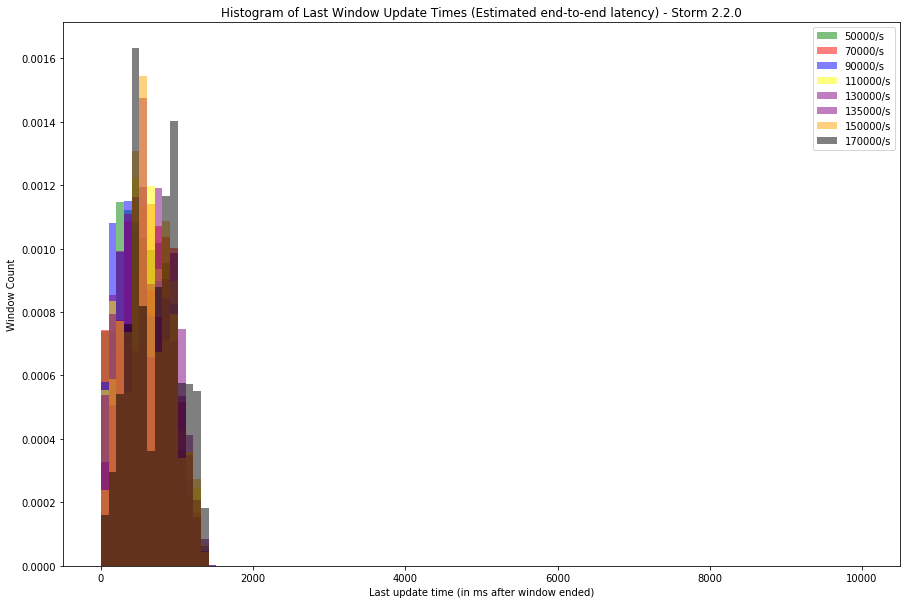

In [64]:
window_size_ms = 10000   #10 seconds (for me). Adjust to match your benchmark and common component.

files = [("../runs/results/STORM/50000/updated.txt", "green", "50000"),
         ("../runs/results/STORM/70000/updated.txt", "red", "70000"),
         ("../runs/results/STORM/90000/updated.txt", "blue", "90000"),
         ("../runs/results/STORM/110000/updated.txt", "yellow", "110000"),
         ("../runs/results/STORM/130000/updated.txt", "purple", "130000"),
         ("../runs/results/STORM/135000/updated.txt", "purple", "135000"),
         ("../runs/results/STORM/150000/updated.txt", "orange", "150000"),
         ("../runs/results/STORM/170000/updated.txt", "black", "170000")]

filtered = [(get_filtered_updated(filename, window_size_ms), color, label) for (filename, color, label) in files]
bins = np.linspace(0, 10000, 100)

f = plt.figure(num=None, figsize=(15, 10))
for (filter_each, color, label) in filtered:
    plt.hist(filter_each, bins, density=1, facecolor=color, alpha=0.5, label=label+"/s") 
plt.xlabel('Last update time (in ms after window ended)')
plt.ylabel('Window Count')
plt.title('Histogram of Last Window Update Times (Estimated end-to-end latency) - Storm 2.2.0')
plt.legend(loc="upper right")
plt.show()
f.savefig("Storm_220_hist.pdf", bbox_inches='tight')

## Percentiles

Percentiles for the last-update time. 90th percentile being within 1000ms or so indicates that the topology is keeping up with the throughput.


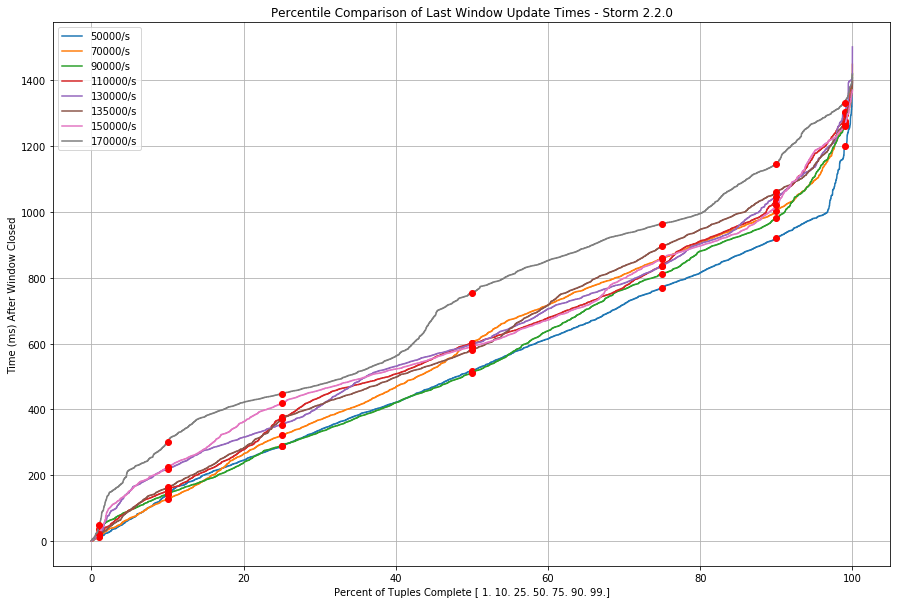

Percentiles:  [ 1. 10. 25. 50. 75. 90. 99.]


In [65]:
#Draws percentile charts from tuples of ([points], [percentiles], label)
def draw_line(points, percentiles, label):    
    plt.plot(np.linspace(0,100, len(points)), points, label=(label + "/s"))
    plt.plot(p, percentiles, 'ro')

# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

sorted = [(np.sort(filter), np.percentile(np.sort(filter), p), label) for (filter, _, label) in filtered]

# Do the drawing
f = plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in sorted:
    draw_line(points, percentiles,label)

plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After Window Closed')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Storm 2.2.0')
plt.show()

print("Percentiles: ", p)
f.savefig("Storm_220_LWU.pdf", bbox_inches='tight')

### *Late* Publishes
Here are the percentiles for the windows that were published *after* the expected 1000ms cutoff:

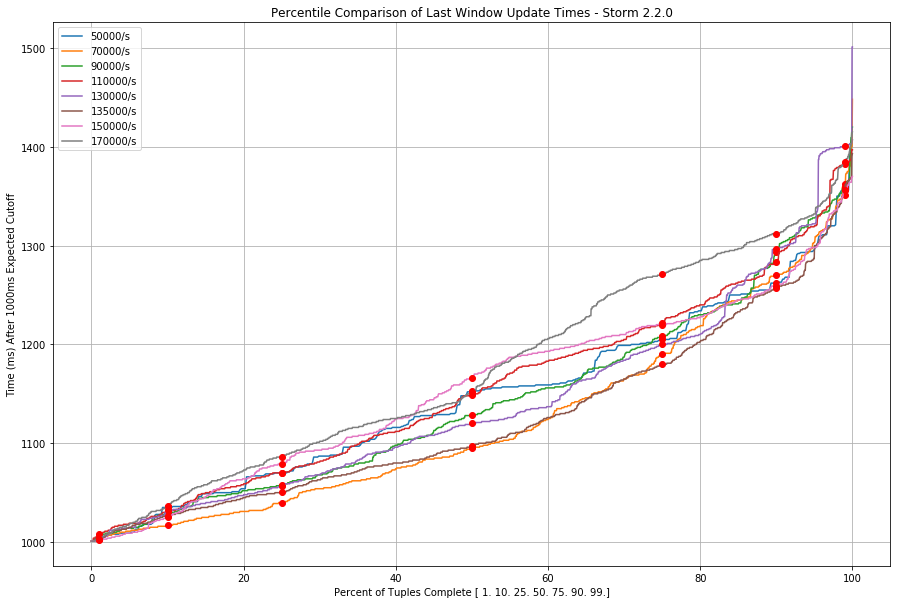

In [66]:
# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

def filter_and_sort(sorted_each, _, label):
    filtered_sorted = [x for x in sorted_each if x > 1000]
    perc = np.percentile(filtered_sorted, p)
    return (filtered_sorted, perc, label)

# Filter all data points <= 1000 ms
filtered_sorted = list()

for (sorted_each, _, label) in sorted:
    filtered_sorted.append(filter_and_sort(sorted_each, _, label))

# Do the actual drawing
plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in filtered_sorted:
    draw_line(points, percentiles, label)
    
plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After 1000ms Expected Cutoff')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Storm 2.2.0')
plt.show()

# Flink Benchmarks - 1.11.0

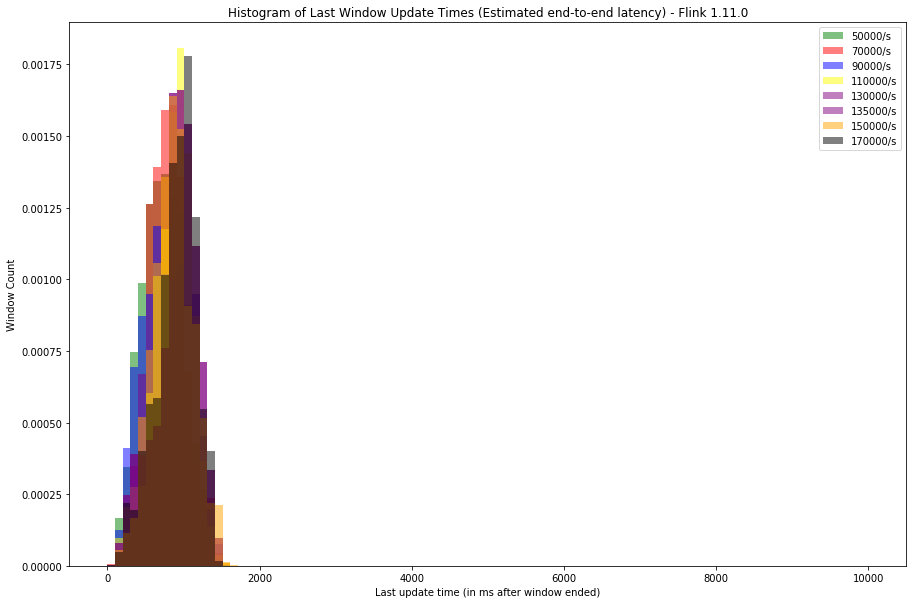

In [67]:
window_size_ms = 10000   #10 seconds (for me). Adjust to match your benchmark and common component.

files = [("../runs/results_flink-1.11.0/FLINK/50000/updated.txt", "green", "50000"),
         ("../runs/results_flink-1.11.0/FLINK/70000/updated.txt", "red", "70000"),
         ("../runs/results_flink-1.11.0/FLINK/90000/updated.txt", "blue", "90000"),
         ("../runs/results_flink-1.11.0/FLINK/110000/updated.txt", "yellow", "110000"),
         ("../runs/results_flink-1.11.0/FLINK/130000/updated.txt", "purple", "130000"),
         ("../runs/results_flink-1.11.0/FLINK/130000/updated.txt", "purple", "135000"),
         ("../runs/results_flink-1.11.0/FLINK/150000/updated.txt", "orange", "150000"),
         ("../runs/results_flink-1.11.0/FLINK/170000/updated.txt", "black", "170000")]

filtered = [(get_filtered_updated(filename, window_size_ms), color, label) for (filename, color, label) in files]
bins = np.linspace(0, 10000, 100)

f = plt.figure(num=None, figsize=(15, 10))
for (filter_each, color, label) in filtered:
    plt.hist(filter_each, bins, density=1, facecolor=color, alpha=0.5, label=label+"/s") 
plt.xlabel('Last update time (in ms after window ended)')
plt.ylabel('Window Count')
plt.title('Histogram of Last Window Update Times (Estimated end-to-end latency) - Flink 1.11.0')
plt.legend(loc="upper right")
plt.show()
f.savefig("Flink_110_hist.pdf", bbox_inches='tight')

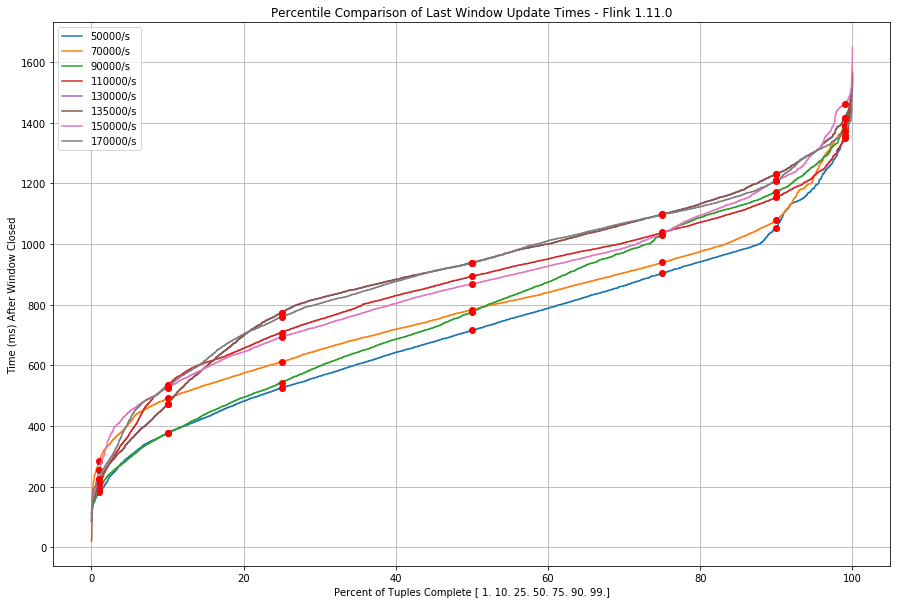

Percentiles:  [ 1. 10. 25. 50. 75. 90. 99.]


In [68]:
#Draws percentile charts from tuples of ([points], [percentiles], label)
def draw_line(points, percentiles, label):    
    plt.plot(np.linspace(0,100, len(points)), points, label=(label + "/s"))
    plt.plot(p, percentiles, 'ro')

# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

sorted = [(np.sort(filter), np.percentile(np.sort(filter), p), label) for (filter, _, label) in filtered]

# Do the drawing
f = plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in sorted:
    draw_line(points, percentiles,label)

plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After Window Closed')
plt.title('Percentile Comparison of Last Window Update Times - Flink 1.11.0')
plt.grid(True)
plt.show()

print("Percentiles: ", p)
f.savefig("Flink_110_LWU.pdf", bbox_inches='tight')

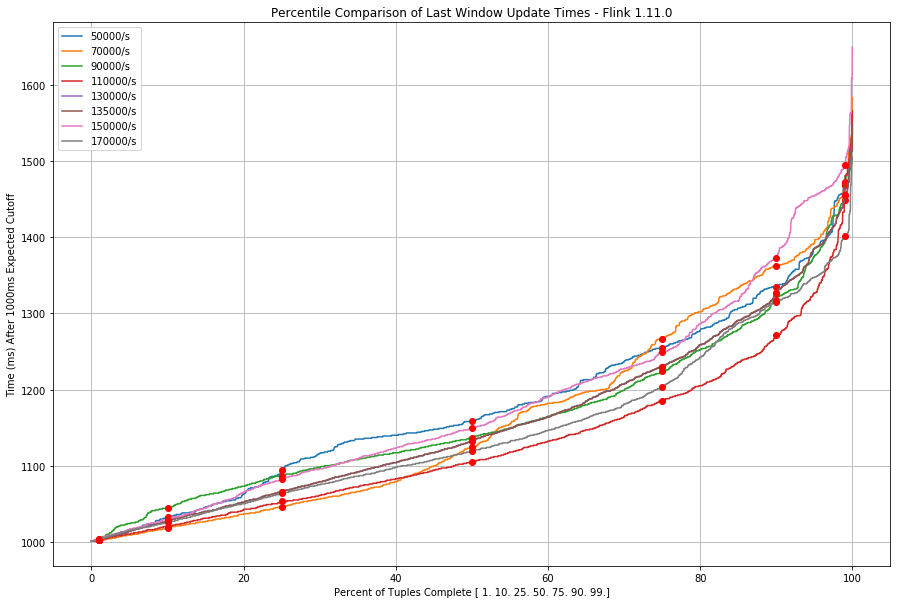

In [69]:
# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

def filter_and_sort(sorted_each, _, label):
    filtered_sorted = [x for x in sorted_each if x > 1000]
    perc = np.percentile(filtered_sorted, p)
    return (filtered_sorted, perc, label)

# Filter all data points <= 1000 ms
filtered_sorted = list()

for (sorted_each, _, label) in sorted:
    filtered_sorted.append(filter_and_sort(sorted_each, _, label))

# Do the actual drawing
plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in filtered_sorted:
    draw_line(points, percentiles, label)
    
plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After 1000ms Expected Cutoff')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Flink 1.11.0')
plt.show()

# DStream Spark Benchmarks - 3.0 - Micro batch interval 3 secs

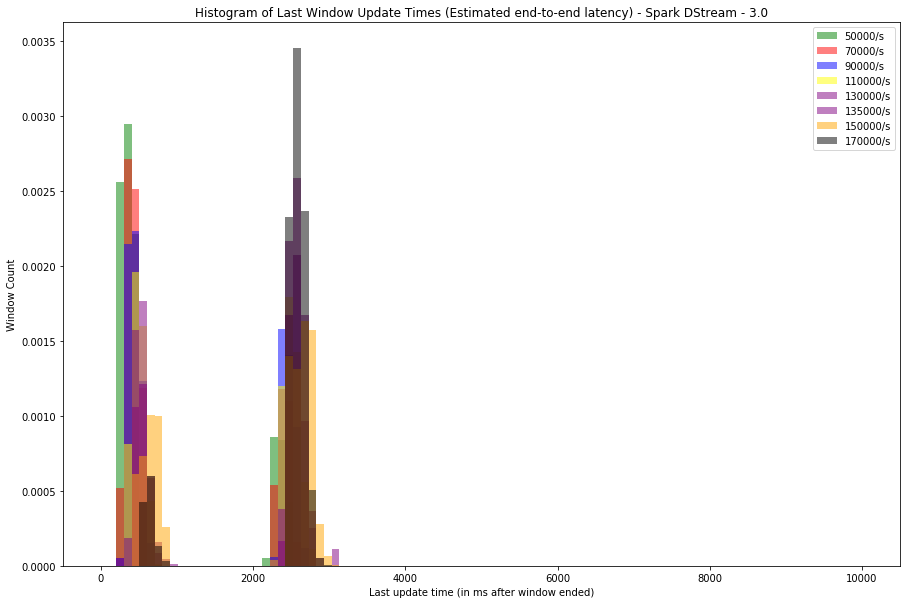

In [70]:
window_size_ms = 10000   #10 seconds (for me). Adjust to match your benchmark and common component.

files = [("../runs/results/SPARK/50000/updated.txt", "green", "50000"),
         ("../runs/results/SPARK/70000/updated.txt", "red", "70000"),
         ("../runs/results/SPARK/90000/updated.txt", "blue", "90000"),
         ("../runs/results/SPARK/110000/updated.txt", "yellow", "110000"),
         ("../runs/results/SPARK/130000/updated.txt", "purple", "130000"),
         ("../runs/results/SPARK/135000/updated.txt", "purple", "135000"),
         ("../runs/results/SPARK/150000/updated.txt", "orange", "150000"),
         ("../runs/results/SPARK/170000/updated.txt", "black", "170000")]

filtered = [(get_filtered_updated(filename, window_size_ms), color, label) for (filename, color, label) in files]
bins = np.linspace(0, 10000, 100)

f = plt.figure(num=None, figsize=(15, 10))
for (filter_each, color, label) in filtered:
    plt.hist(filter_each, bins, density=1, facecolor=color, alpha=0.5, label=label+"/s") 
plt.xlabel('Last update time (in ms after window ended)')
plt.ylabel('Window Count')
plt.title('Histogram of Last Window Update Times (Estimated end-to-end latency) - Spark DStream - 3.0')
plt.legend(loc="upper right")
plt.show()
f.savefig("Spark_DStream_30_hist.pdf", bbox_inches='tight')

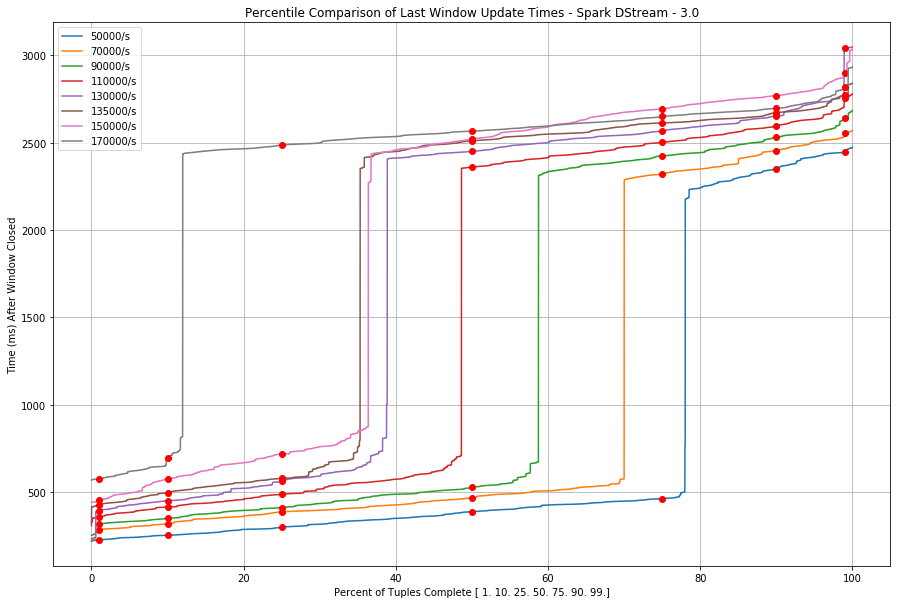

Percentiles:  [ 1. 10. 25. 50. 75. 90. 99.]


In [71]:
#Draws percentile charts from tuples of ([points], [percentiles], label)
def draw_line(points, percentiles, label):    
    plt.plot(np.linspace(0,100, len(points)), points, label=(label + "/s"))
    plt.plot(p, percentiles, 'ro')

# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

sorted = [(np.sort(filter), np.percentile(np.sort(filter), p), label) for (filter, _, label) in filtered]

# Do the drawing
f = plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in sorted:
    draw_line(points, percentiles,label)

plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After Window Closed')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Spark DStream - 3.0')
plt.show()
f.savefig("Spark_DStream_30_LWU.pdf", bbox_inches='tight')
print("Percentiles: ", p)

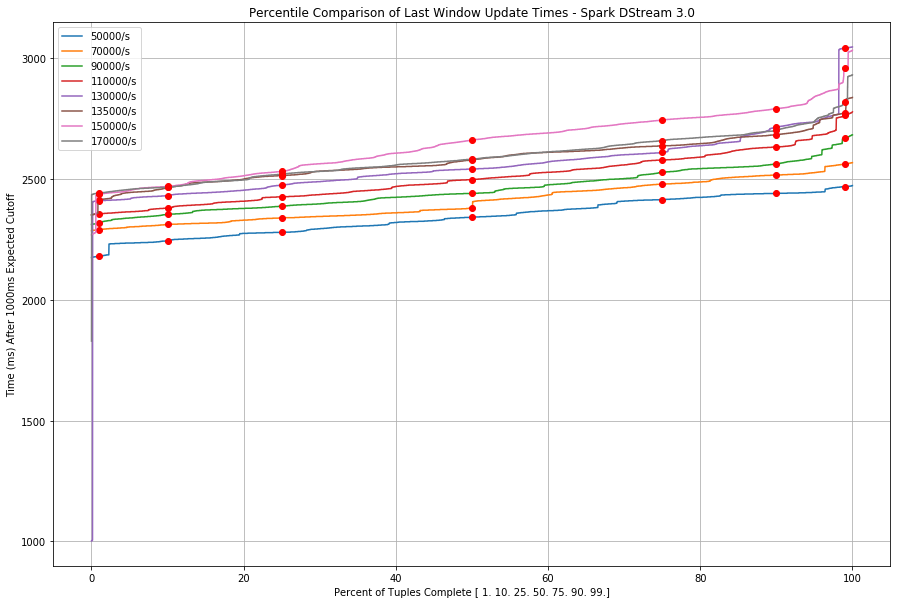

In [72]:
# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

def filter_and_sort(sorted_each, _, label):
    filtered_sorted = [x for x in sorted_each if x > 1000]
    perc = np.percentile(filtered_sorted, p)
    return (filtered_sorted, perc, label)

# Filter all data points <= 1000 ms
filtered_sorted = list()

for (sorted_each, _, label) in sorted:
    filtered_sorted.append(filter_and_sort(sorted_each, _, label))

# Do the actual drawing
plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in filtered_sorted:
    draw_line(points, percentiles, label)
    
plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After 1000ms Expected Cutoff')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Spark DStream 3.0')
plt.show()

# Spark Structured Streaming Benchmarks 3.0 - Continuous Mode - Trigger 1s

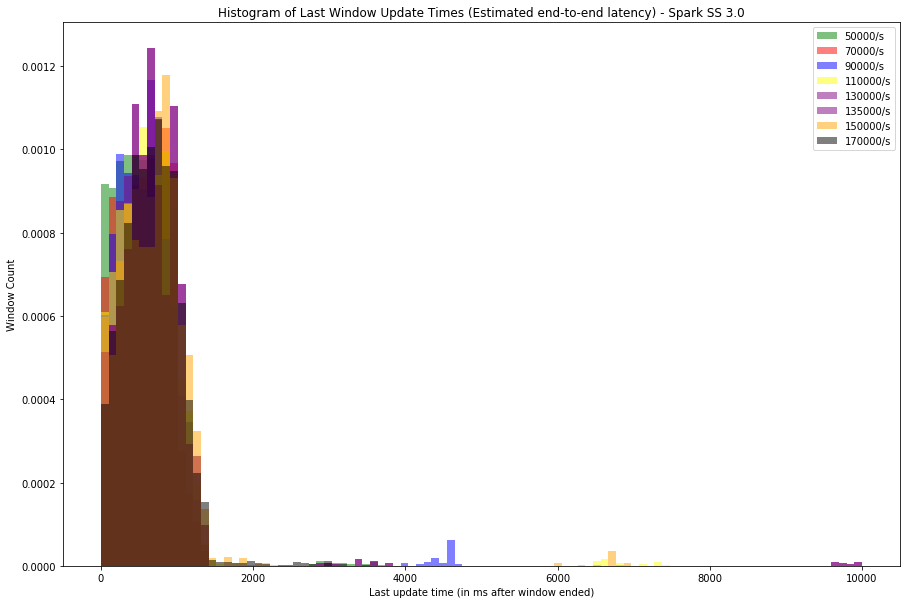

In [73]:
window_size_ms = 10000   #10 seconds (for me). Adjust to match your benchmark and common component.

files = [("../runs/results/SS_SPARK/50000/updated.txt", "green", "50000"),
         ("../runs/results/SS_SPARK/70000/updated.txt", "red", "70000"),
         ("../runs/results/SS_SPARK/90000/updated.txt", "blue", "90000"),
         ("../runs/results/SS_SPARK/110000/updated.txt", "yellow", "110000"),
         ("../runs/results/SS_SPARK/130000/updated.txt", "purple", "130000"),
         ("../runs/results/SS_SPARK/130000/updated.txt", "purple", "135000"),
         ("../runs/results/SS_SPARK/150000/updated.txt", "orange", "150000"),
         ("../runs/results/SS_SPARK/170000/updated.txt", "black", "170000")]

filtered = [(get_filtered_updated(filename, window_size_ms), color, label) for (filename, color, label) in files]
bins = np.linspace(0, 10000, 100)

f = plt.figure(num=None, figsize=(15, 10))
for (filter_each, color, label) in filtered:
    plt.hist(filter_each, bins, density=1, facecolor=color, alpha=0.5, label=label+"/s") 
plt.xlabel('Last update time (in ms after window ended)')
plt.ylabel('Window Count')
plt.title('Histogram of Last Window Update Times (Estimated end-to-end latency) - Spark SS 3.0')
plt.legend(loc="upper right")
plt.show()
f.savefig("Spark_SS_30_hist.pdf", bbox_inches='tight')

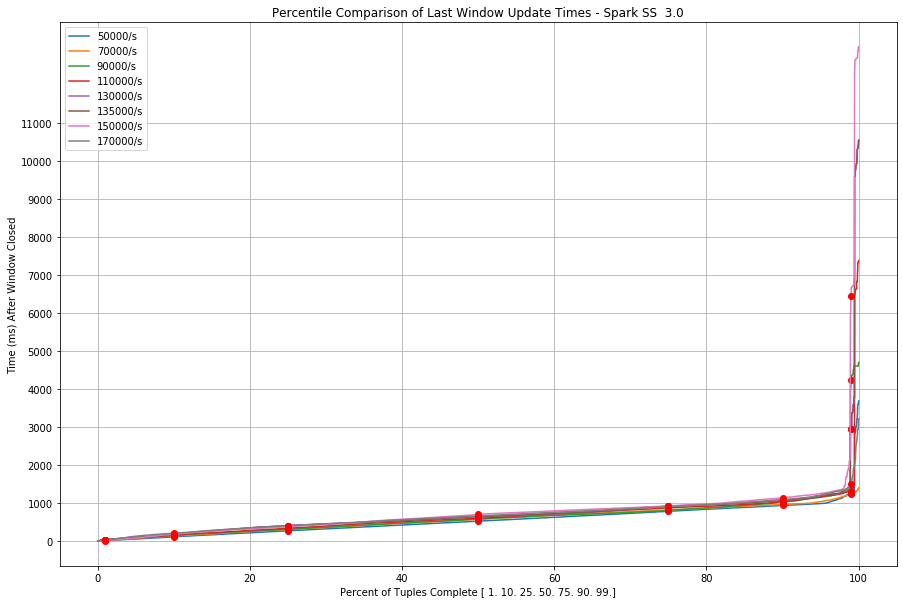

Percentiles:  [ 1. 10. 25. 50. 75. 90. 99.]


In [74]:
#Draws percentile charts from tuples of ([points], [percentiles], label)
def draw_line(points, percentiles, label):    
    plt.plot(np.linspace(0,100, len(points)), points, label=(label + "/s"))
    plt.plot(p, percentiles, 'ro')

# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

sorted = [(np.sort(filter), np.percentile(np.sort(filter), p), label) for (filter, _, label) in filtered]

# Do the drawing
f = plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in sorted:
    draw_line(points, percentiles,label)

plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After Window Closed')
plt.yticks(np.arange(0,12000,1000))
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Spark SS  3.0')
plt.show()
f.savefig("Spark_SS_30_LWU.pdf", bbox_inches='tight')
print("Percentiles: ", p)

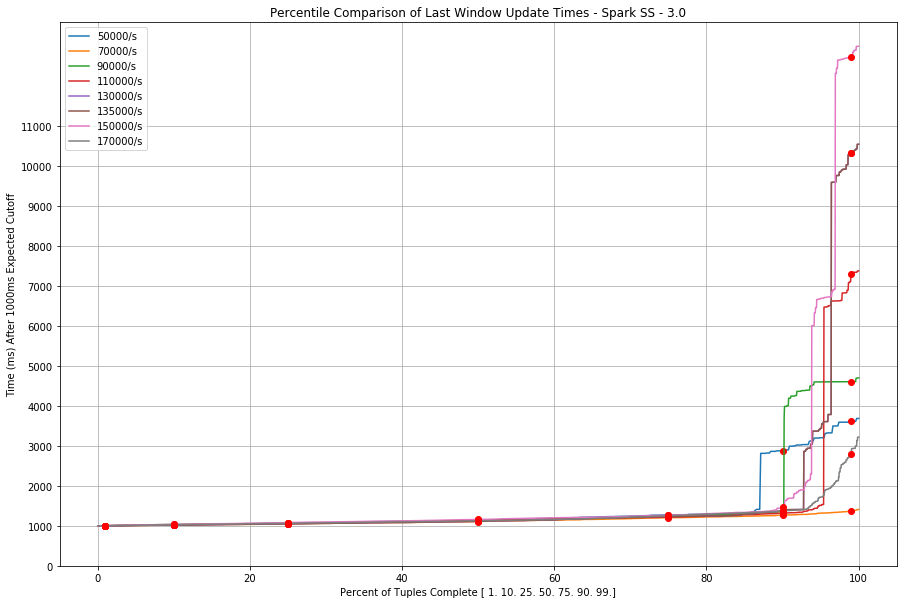

In [75]:
# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

def filter_and_sort(sorted_each, _, label):
    filtered_sorted = [x for x in sorted_each if x > 1000]
    perc = np.percentile(filtered_sorted, p)
    return (filtered_sorted, perc, label)

# Filter all data points <= 1000 ms
filtered_sorted = list()

for (sorted_each, _, label) in sorted:
    filtered_sorted.append(filter_and_sort(sorted_each, _, label))

# Do the actual drawing
plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in filtered_sorted:
    draw_line(points, percentiles, label)
    
plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After 1000ms Expected Cutoff')
plt.yticks(np.arange(0,12000,1000))
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Spark SS - 3.0')
plt.show()

# Beam Flink Runner Benchmarks - 1.9.0 (beam-flink-runner-1.9 Beam 2.22.0)

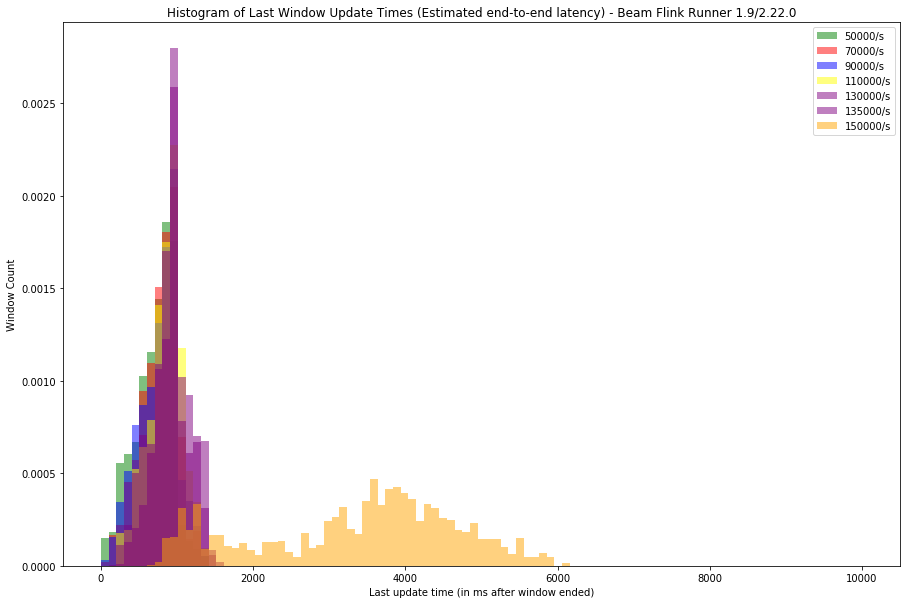

In [76]:
window_size_ms = 10000   #10 seconds (for me). Adjust to match your benchmark and common component.

files = [("../runs/results/BEAM_FLINK/50000/updated.txt", "green", "50000"),
         ("../runs/results/BEAM_FLINK/70000/updated.txt", "red", "70000"),
         ("../runs/results/BEAM_FLINK/90000/updated.txt", "blue", "90000"),
         ("../runs/results/BEAM_FLINK/110000/updated.txt", "yellow", "110000"),
         ("../runs/results/BEAM_FLINK/130000/updated.txt", "purple", "130000"),
         ("../runs/results/BEAM_FLINK/135000/updated.txt", "purple", "135000"),
         # Beam cannot keep up at 150000 events
         ("../runs/results/BEAM_FLINK/150000/updated.txt", "orange", "150000")]
         #("../runs/results/BEAM_FLINK/170000/updated.txt", "black", "170000")]

filtered = [(get_filtered_updated(filename, window_size_ms), color, label) for (filename, color, label) in files]
bins = np.linspace(0, 10000, 100)

f = plt.figure(num=None, figsize=(15, 10))
for (filter_each, color, label) in filtered:
    plt.hist(filter_each, bins, density=1, facecolor=color, alpha=0.5, label=label+"/s") 
plt.xlabel('Last update time (in ms after window ended)')
plt.ylabel('Window Count')
plt.title('Histogram of Last Window Update Times (Estimated end-to-end latency) - Beam Flink Runner 1.9/2.22.0')
plt.legend(loc="upper right")
plt.show()
f.savefig("Beam_Flink_hist.pdf", bbox_inches='tight')

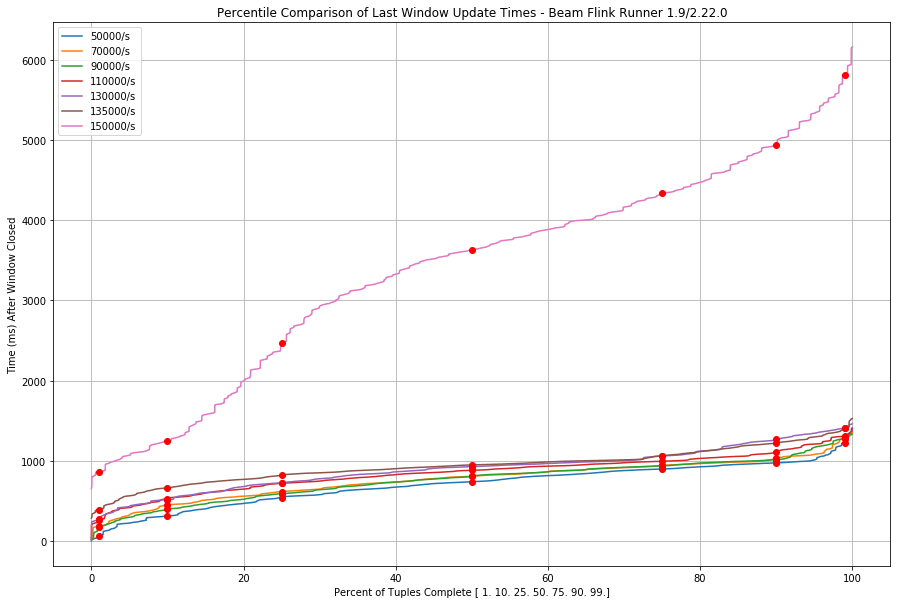

Percentiles:  [ 1. 10. 25. 50. 75. 90. 99.]


In [77]:
#Draws percentile charts from tuples of ([points], [percentiles], label)
def draw_line(points, percentiles, label):    
    plt.plot(np.linspace(0,100, len(points)), points, label=(label + "/s"))
    plt.plot(p, percentiles, 'ro')

# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

sorted = [(np.sort(filter), np.percentile(np.sort(filter), p), label) for (filter, _, label) in filtered]

# Do the drawing
f = plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in sorted:
    draw_line(points, percentiles,label)

plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After Window Closed')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Beam Flink Runner 1.9/2.22.0')
plt.show()
f.savefig("Beam_Flink_LWU_150k.pdf", bbox_inches='tight')
print("Percentiles: ", p)

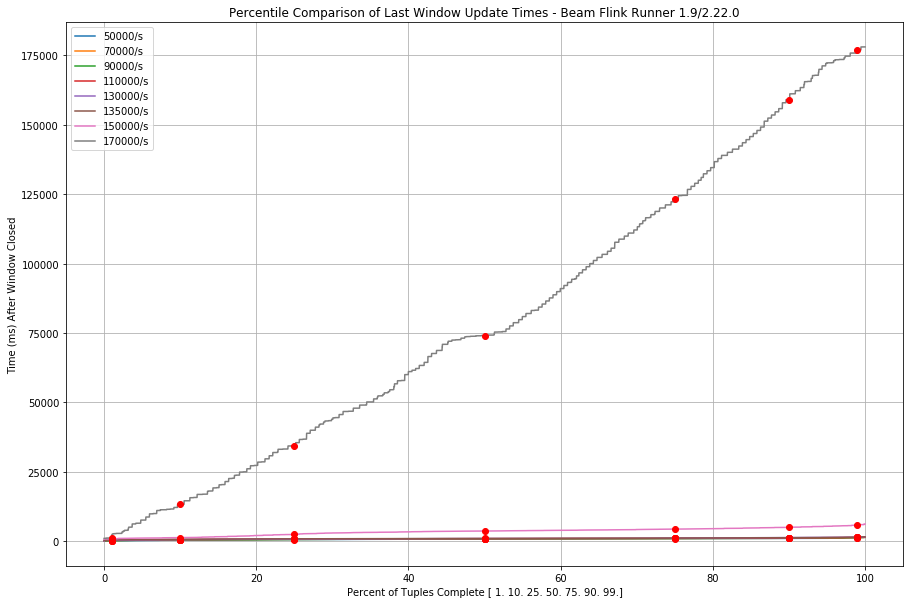

Percentiles:  [ 1. 10. 25. 50. 75. 90. 99.]


In [78]:
window_size_ms = 10000   #10 seconds (for me). Adjust to match your benchmark and common component.

files = [("../runs/results/BEAM_FLINK/50000/updated.txt", "green", "50000"),
         ("../runs/results/BEAM_FLINK/70000/updated.txt", "red", "70000"),
         ("../runs/results/BEAM_FLINK/90000/updated.txt", "blue", "90000"),
         ("../runs/results/BEAM_FLINK/110000/updated.txt", "yellow", "110000"),
         ("../runs/results/BEAM_FLINK/130000/updated.txt", "purple", "130000"),
         ("../runs/results/BEAM_FLINK/135000/updated.txt", "purple", "135000"),
         # Beam cannot keep up at 150000 events
         ("../runs/results/BEAM_FLINK/150000/updated.txt", "orange", "150000"),
         ("../runs/results/BEAM_FLINK/170000/updated.txt", "black", "170000")]

filtered = [(get_filtered_updated(filename, window_size_ms), color, label) for (filename, color, label) in files]
#Draws percentile charts from tuples of ([points], [percentiles], label)
def draw_line(points, percentiles, label):    
    plt.plot(np.linspace(0,100, len(points)), points, label=(label + "/s"))
    plt.plot(p, percentiles, 'ro')

# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

sorted = [(np.sort(filter), np.percentile(np.sort(filter), p), label) for (filter, _, label) in filtered]

# Do the drawing
f = plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in sorted:
    draw_line(points, percentiles,label)

plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After Window Closed')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Beam Flink Runner 1.9/2.22.0')
plt.show()
f.savefig("Beam_Flink_LWU_170k.pdf", bbox_inches='tight')
print("Percentiles: ", p)

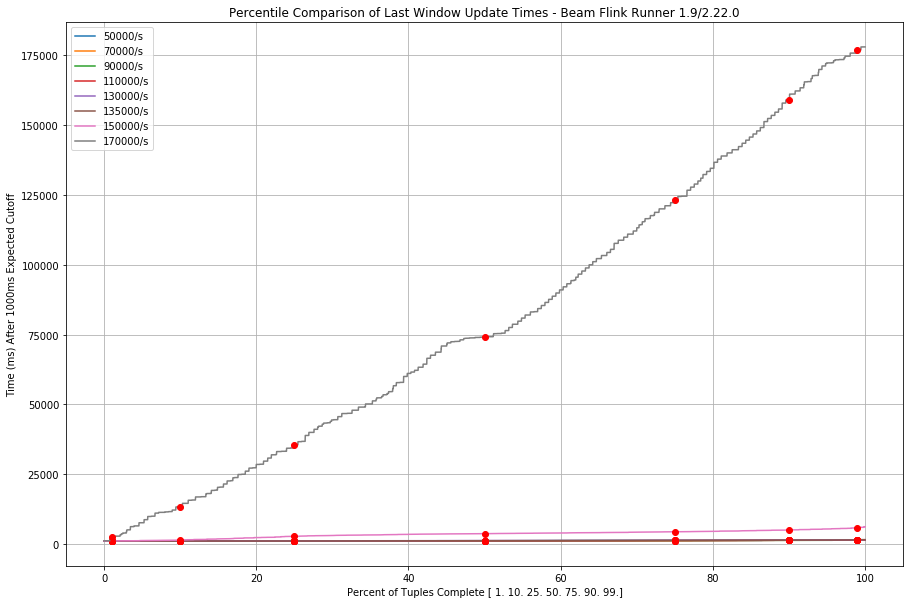

In [79]:
# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

def filter_and_sort(sorted_each, _, label):
    filtered_sorted = [x for x in sorted_each if x > 1000]
    perc = np.percentile(filtered_sorted, p)
    return (filtered_sorted, perc, label)

# Filter all data points <= 1000 ms
filtered_sorted = list()

for (sorted_each, _, label) in sorted:
    filtered_sorted.append(filter_and_sort(sorted_each, _, label))

# Do the actual drawing
plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in filtered_sorted:
    draw_line(points, percentiles, label)
    
plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After 1000ms Expected Cutoff')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Beam Flink Runner 1.9/2.22.0')
plt.show()

# Beam Spark Runner Benchmarks - (beam-spark-runner Beam 2.22.0 on Spark 2.4.6) Micro batch interval 3 secs 
Note: Spark Structured Streaming for Beam only supports Bounded batch processing hence not useful to perform benchmarks for streaming frameworks

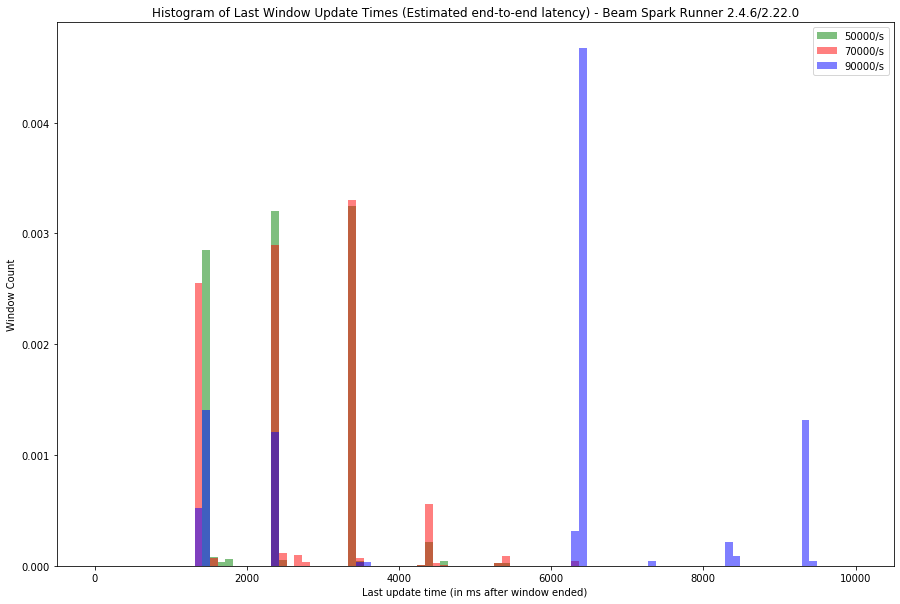

In [80]:
window_size_ms = 10000   #10 seconds (for me). Adjust to match your benchmark and common component.

files = [("../runs/results/BEAM_SPARK/50000/updated.txt", "green", "50000"),
         ("../runs/results/BEAM_SPARK/70000/updated.txt", "red", "70000"),
         ("../runs/results/BEAM_SPARK/90000/updated.txt", "blue", "90000")]
         #("./results/BEAM_SPARK/110000/updated.txt", "yellow", "110000"),
         #("./results/BEAM_SPARK/130000/updated.txt", "purple", "130000"),
         #("./results/BEAM_SPARK/135000/updated.txt", "purple", "135000"),
         #("./results/BEAM_SPARK/150000/updated.txt", "orange", "150000"),
         #("./results/BEAM_SPARK/170000/updated.txt", "black", "170000")]

filtered = [(get_filtered_updated(filename, window_size_ms), color, label) for (filename, color, label) in files]
bins = np.linspace(0, 10000, 100)

f = plt.figure(num=None, figsize=(15, 10))
for (filter_each, color, label) in filtered:
    plt.hist(filter_each, bins, density=1, facecolor=color, alpha=0.5, label=label+"/s") 
plt.xlabel('Last update time (in ms after window ended)')
plt.ylabel('Window Count')
plt.title('Histogram of Last Window Update Times (Estimated end-to-end latency) - Beam Spark Runner 2.4.6/2.22.0')
plt.legend(loc="upper right")
plt.show()
f.savefig("Beam_Spark_hist.pdf", bbox_inches='tight')

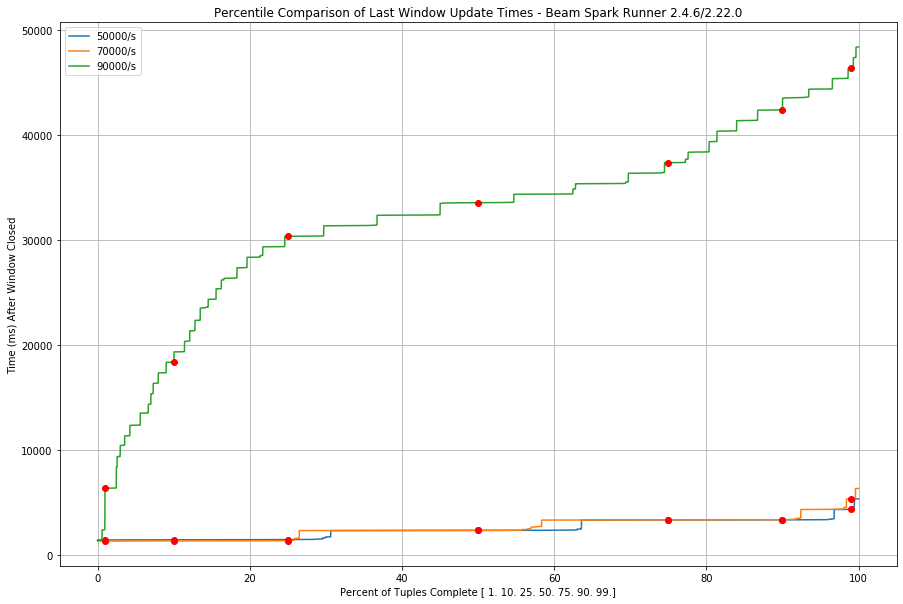

Percentiles:  [ 1. 10. 25. 50. 75. 90. 99.]


In [81]:
#Draws percentile charts from tuples of ([points], [percentiles], label)
def draw_line(points, percentiles, label):    
    plt.plot(np.linspace(0,100, len(points)), points, label=(label + "/s"))
    plt.plot(p, percentiles, 'ro')

# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

sorted = [(np.sort(filter), np.percentile(np.sort(filter), p), label) for (filter, _, label) in filtered]

# Do the drawing
f = plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in sorted:
    draw_line(points, percentiles,label)

plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After Window Closed')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Beam Spark Runner 2.4.6/2.22.0')
plt.show()
f.savefig("Beam_Spark_LWU_90k.pdf", bbox_inches='tight')
print("Percentiles: ", p)

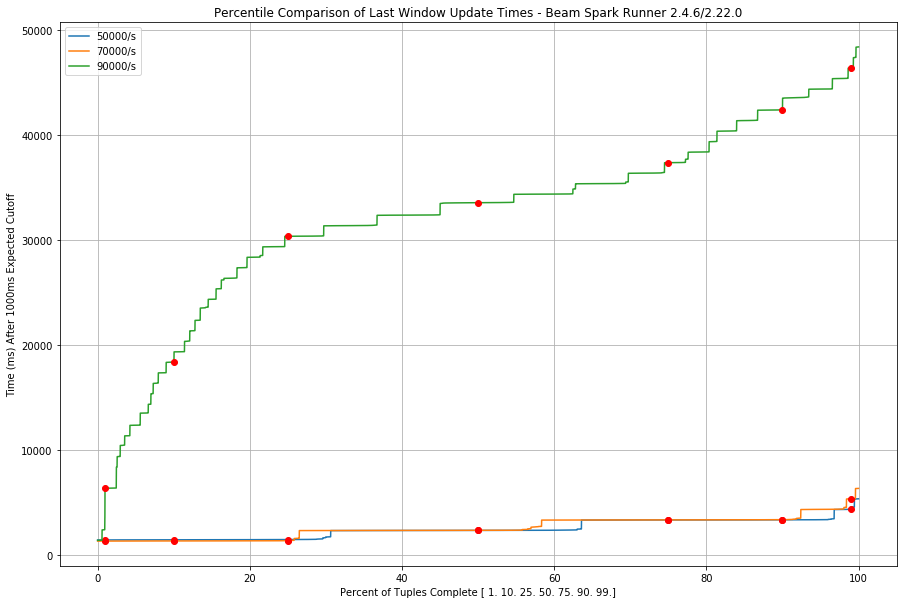

In [82]:
# Percentile values
window_size_ms = 10000   #10 seconds (for me). Adjust to match your benchmark and common component.

files = [("../runs/results/BEAM_SPARK/50000/updated.txt", "green", "50000"),
         ("../runs/results/BEAM_SPARK/70000/updated.txt", "red", "70000")]
         #("../runs/results/BEAM_SPARK/90000/updated.txt", "blue", "90000")]
         #("./results/BEAM_SPARK/110000/updated.txt", "yellow", "110000"),
         #("./results/BEAM_SPARK/130000/updated.txt", "purple", "130000"),
         #("./results/BEAM_SPARK/135000/updated.txt", "purple", "135000"),
         #("./results/BEAM_SPARK/150000/updated.txt", "orange", "150000"),
         #("./results/BEAM_SPARK/170000/updated.txt", "black", "170000")]

filtered = [(get_filtered_updated(filename, window_size_ms), color, label) for (filename, color, label) in files]

p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

def filter_and_sort(sorted_each, _, label):
    filtered_sorted = [x for x in sorted_each if x > 1000]
    perc = np.percentile(filtered_sorted, p)
    return (filtered_sorted, perc, label)

# Filter all data points <= 1000 ms
filtered_sorted = list()

for (sorted_each, _, label) in sorted:
    filtered_sorted.append(filter_and_sort(sorted_each, _, label))

# Do the actual drawing
plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in filtered_sorted:
    draw_line(points, percentiles, label)
    
plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After 1000ms Expected Cutoff')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Beam Spark Runner 2.4.6/2.22.0')
plt.show()

# Benchmarks with acking/checkpoints enabled

# Storm 10 Ackers

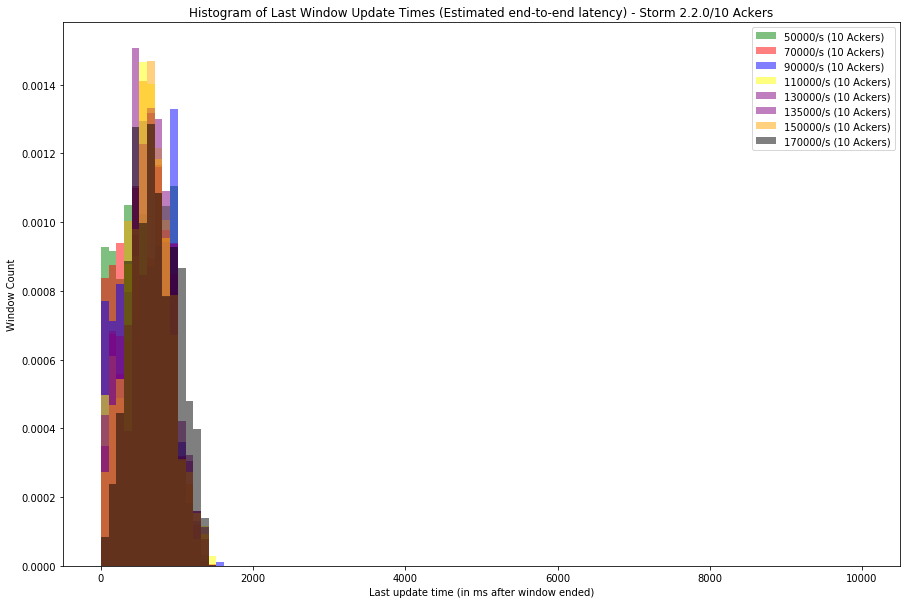

In [83]:
window_size_ms = 10000   #10 seconds (for me). Adjust to match your benchmark and common component.

files = [("../runs/results_chkpt/STORM/50000/updated.txt", "green", "50000"),
         ("../runs/results_chkpt/STORM/70000/updated.txt", "red", "70000"),
         ("../runs/results_chkpt/STORM/90000/updated.txt", "blue", "90000"),
         ("../runs/results_chkpt/STORM/110000/updated.txt", "yellow", "110000"),
         ("../runs/results_chkpt/STORM/130000/updated.txt", "purple", "130000"),
         ("../runs/results_chkpt/STORM/135000/updated.txt", "purple", "135000"),
         ("../runs/results_chkpt/STORM/150000/updated.txt", "orange", "150000"),
         ("../runs/results_chkpt/STORM/170000/updated.txt", "black", "170000")]

filtered = [(get_filtered_updated(filename, window_size_ms), color, label) for (filename, color, label) in files]
bins = np.linspace(0, 10000, 100)

f = plt.figure(num=None, figsize=(15, 10))
for (filter_each, color, label) in filtered:
    plt.hist(filter_each, bins, density=1, facecolor=color, alpha=0.5, label=label+"/s (10 Ackers)") 
plt.xlabel('Last update time (in ms after window ended)')
plt.ylabel('Window Count')
plt.title('Histogram of Last Window Update Times (Estimated end-to-end latency) - Storm 2.2.0/10 Ackers')
plt.legend(loc="upper right")
plt.show()
f.savefig("Storm_220_hist_Acking.pdf", bbox_inches='tight')

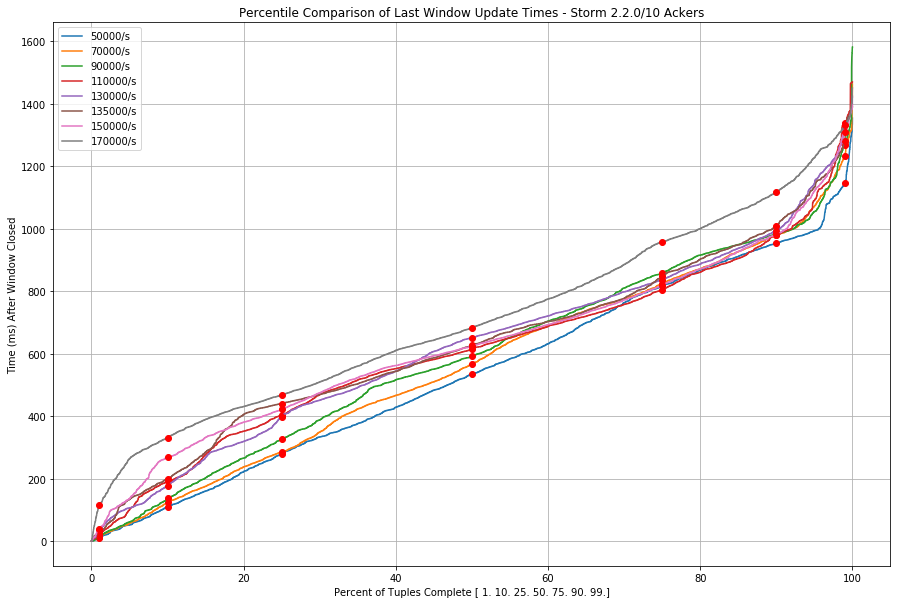

Percentiles:  [ 1. 10. 25. 50. 75. 90. 99.]


In [84]:
#Draws percentile charts from tuples of ([points], [percentiles], label)
def draw_line(points, percentiles, label):    
    plt.plot(np.linspace(0,100, len(points)), points, label=(label + "/s"))
    plt.plot(p, percentiles, 'ro')

# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

sorted = [(np.sort(filter), np.percentile(np.sort(filter), p), label) for (filter, _, label) in filtered]

# Do the drawing
f = plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in sorted:
    draw_line(points, percentiles,label)

plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After Window Closed')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Storm 2.2.0/10 Ackers')
plt.show()

print("Percentiles: ", p)
f.savefig("Storm_220_LWU_Acking.pdf", bbox_inches='tight')

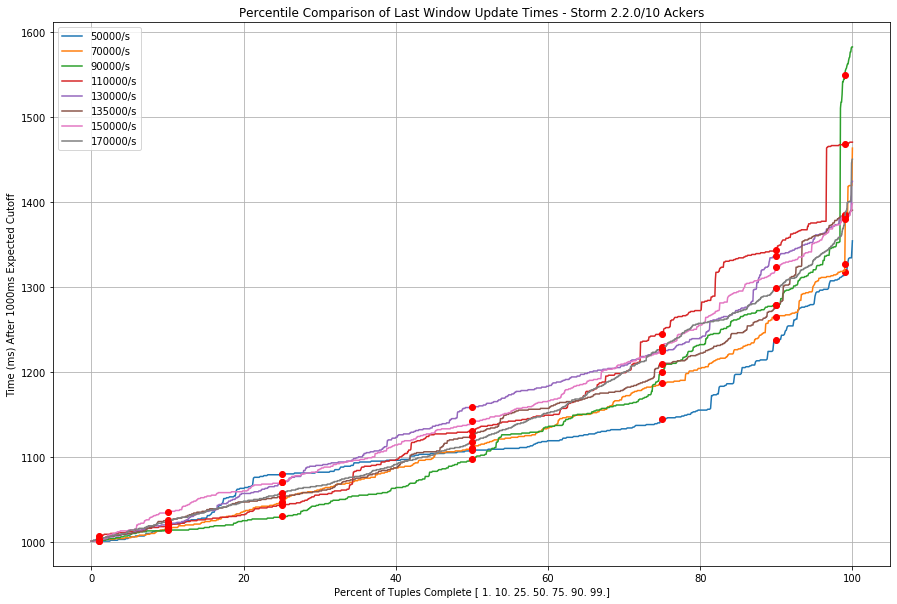

In [85]:
# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

def filter_and_sort(sorted_each, _, label):
    filtered_sorted = [x for x in sorted_each if x > 1000]
    perc = np.percentile(filtered_sorted, p)
    return (filtered_sorted, perc, label)

# Filter all data points <= 1000 ms
filtered_sorted = list()

for (sorted_each, _, label) in sorted:
    filtered_sorted.append(filter_and_sort(sorted_each, _, label))

# Do the actual drawing
plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in filtered_sorted:
    draw_line(points, percentiles, label)
    
plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After 1000ms Expected Cutoff')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Storm 2.2.0/10 Ackers')
plt.show()

# Flink with checkpointing enabled - checkpointing interval 1s

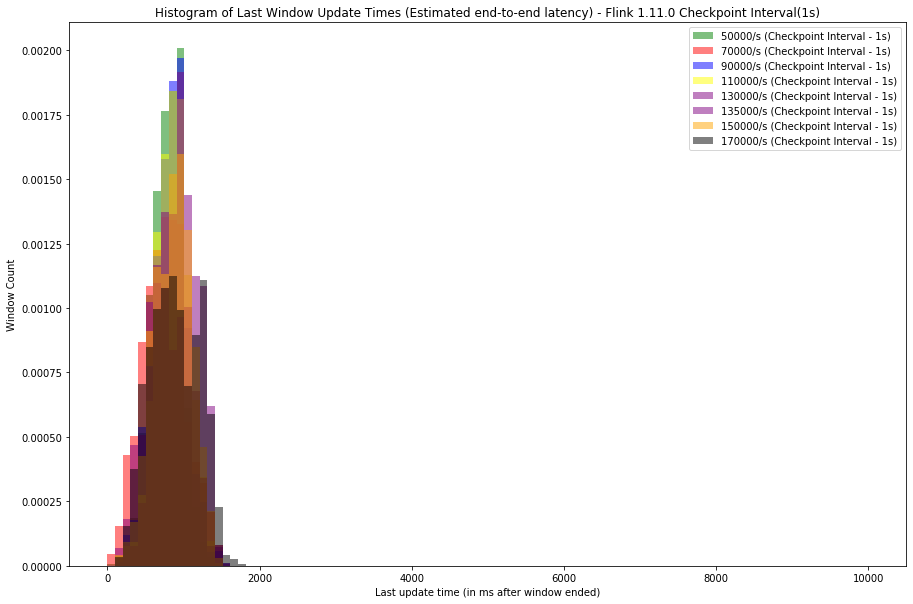

In [86]:
window_size_ms = 10000   #10 seconds (for me). Adjust to match your benchmark and common component.

files = [("../runs/results_chkpt/FLINK/50000/updated.txt", "green", "50000"),
         ("../runs/results_chkpt/FLINK/70000/updated.txt", "red", "70000"),
         ("../runs/results_chkpt/FLINK/90000/updated.txt", "blue", "90000"),
         ("../runs/results_chkpt/FLINK/110000/updated.txt", "yellow", "110000"),
         ("../runs/results_chkpt/FLINK/130000/updated.txt", "purple", "130000"),
         ("../runs/results_chkpt/FLINK/135000/updated.txt", "purple", "135000"),
         ("../runs/results_chkpt/FLINK/150000/updated.txt", "orange", "150000"),
         ("../runs/results_chkpt/FLINK/170000/updated.txt", "black", "170000")]

filtered = [(get_filtered_updated(filename, window_size_ms), color, label) for (filename, color, label) in files]
bins = np.linspace(0, 10000, 100)

f = plt.figure(num=None, figsize=(15, 10))
for (filter_each, color, label) in filtered:
    plt.hist(filter_each, bins, density=1, facecolor=color, alpha=0.5, label=label+"/s (Checkpoint Interval - 1s)") 
plt.xlabel('Last update time (in ms after window ended)')
plt.ylabel('Window Count')
plt.title('Histogram of Last Window Update Times (Estimated end-to-end latency) - Flink 1.11.0 Checkpoint Interval(1s)')
plt.legend(loc="upper right")
plt.show()
f.savefig("Flink_110_hist_checkpoint.pdf", bbox_inches='tight')


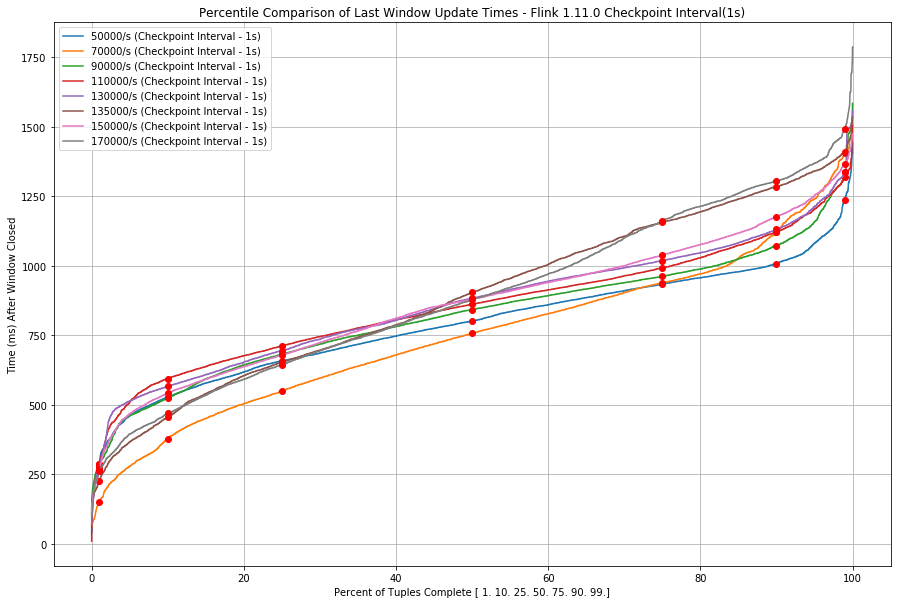

Percentiles:  [ 1. 10. 25. 50. 75. 90. 99.]


In [87]:
#Draws percentile charts from tuples of ([points], [percentiles], label)
def draw_line(points, percentiles, label):    
    plt.plot(np.linspace(0,100, len(points)), points, label=(label + "/s (Checkpoint Interval - 1s)"))
    plt.plot(p, percentiles, 'ro')

# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

sorted = [(np.sort(filter), np.percentile(np.sort(filter), p), label) for (filter, _, label) in filtered]

# Do the drawing
f = plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in sorted:
    draw_line(points, percentiles,label)

plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After Window Closed')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Flink 1.11.0 Checkpoint Interval(1s)')
plt.show()

print("Percentiles: ", p)
f.savefig("Flink_110_LWU_checkpoint.pdf", bbox_inches='tight')

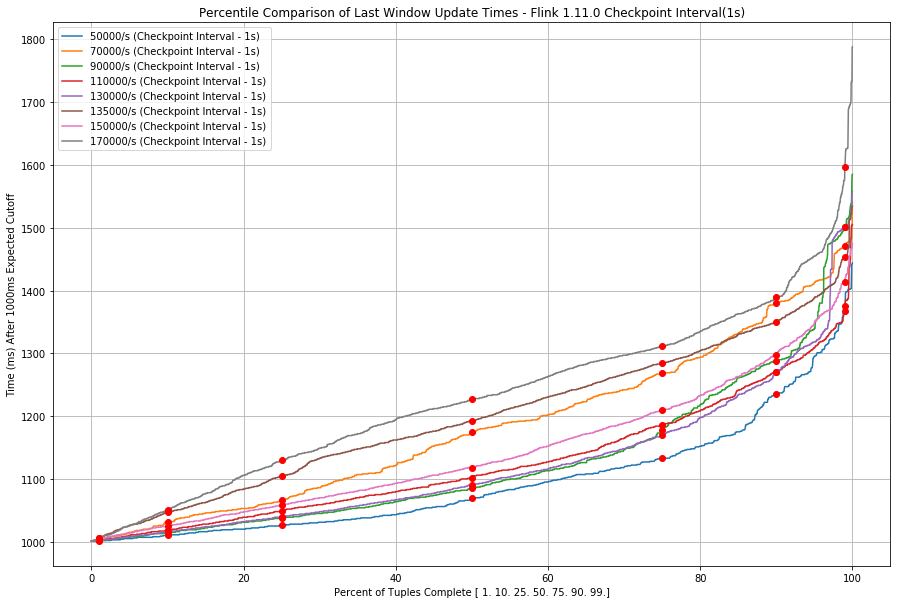

In [88]:
# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

def filter_and_sort(sorted_each, _, label):
    filtered_sorted = [x for x in sorted_each if x > 1000]
    perc = np.percentile(filtered_sorted, p)
    return (filtered_sorted, perc, label)

# Filter all data points <= 1000 ms
filtered_sorted = list()

for (sorted_each, _, label) in sorted:
    filtered_sorted.append(filter_and_sort(sorted_each, _, label))

# Do the actual drawing
plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in filtered_sorted:
    draw_line(points, percentiles, label)
    
plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After 1000ms Expected Cutoff')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Flink 1.11.0 Checkpoint Interval(1s)')
plt.show()

# Beam Flink with checkpointing interval - 1s

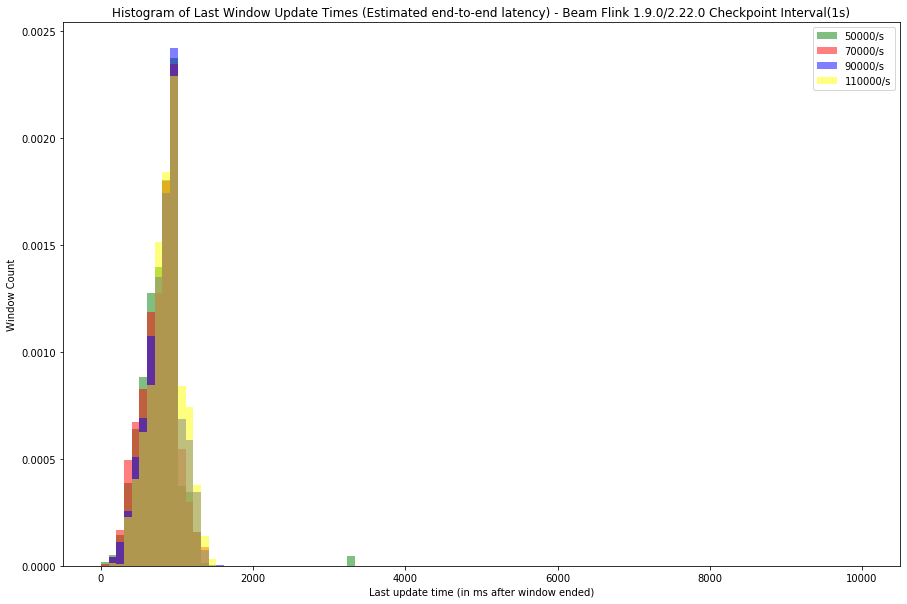

In [89]:
window_size_ms = 10000   #10 seconds (for me). Adjust to match your benchmark and common component.

files = [("../runs/results_chkpt/BEAM_FLINK/50000/updated.txt", "green", "50000"),
         ("../runs/results_chkpt/BEAM_FLINK/70000/updated.txt", "red", "70000"),
         ("../runs/results_chkpt/BEAM_FLINK/90000/updated.txt", "blue", "90000"),
         ("../runs/results_chkpt/BEAM_FLINK/110000/updated.txt", "yellow", "110000")]
         #("../runs/results_chkpt/BEAM_FLINK/130000/updated.txt", "purple", "130000")]
         #("../runs/results_chkpt/BEAM_FLINK/135000/updated.txt", "purple", "135000")]
         #("../runs/results_chkpt/BEAM_FLINK/150000/updated.txt", "orange", "150000"),
         #("../runs/results_chkpt/BEAM_FLINK/170000/updated.txt", "black", "170000")]

filtered = [(get_filtered_updated(filename, window_size_ms), color, label) for (filename, color, label) in files]
bins = np.linspace(0, 10000, 100)

plt.figure(num=None, figsize=(15, 10))
for (filter_each, color, label) in filtered:
    plt.hist(filter_each, bins, density=1, facecolor=color, alpha=0.5, label=label+"/s") 
plt.xlabel('Last update time (in ms after window ended)')
plt.ylabel('Window Count')
plt.title('Histogram of Last Window Update Times (Estimated end-to-end latency) - Beam Flink 1.9.0/2.22.0 Checkpoint Interval(1s)')
plt.legend(loc="upper right")
plt.show()

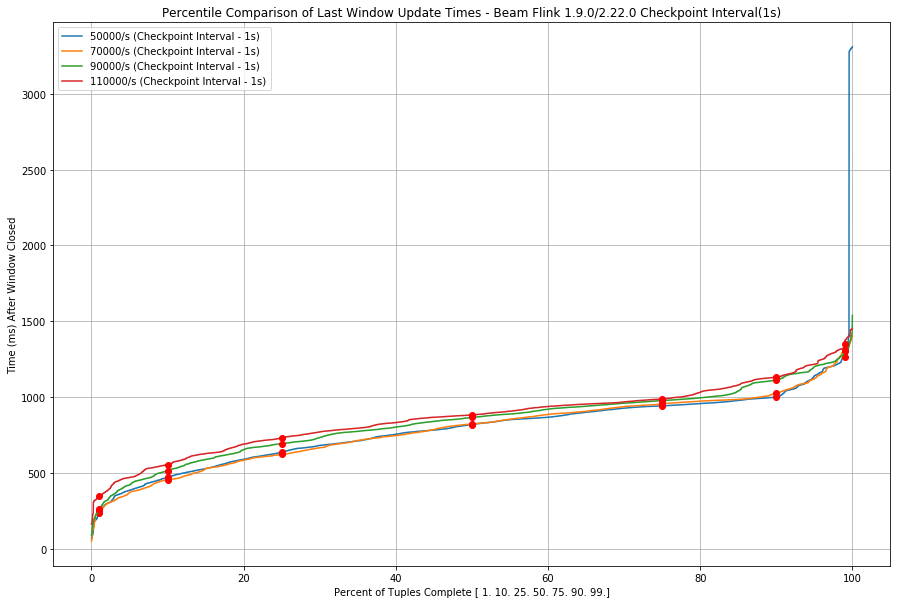

Percentiles:  [ 1. 10. 25. 50. 75. 90. 99.]


In [90]:
#Draws percentile charts from tuples of ([points], [percentiles], label)
def draw_line(points, percentiles, label):    
    plt.plot(np.linspace(0,100, len(points)), points, label=(label + "/s (Checkpoint Interval - 1s)"))
    plt.plot(p, percentiles, 'ro')

# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

sorted = [(np.sort(filter), np.percentile(np.sort(filter), p), label) for (filter, _, label) in filtered]

# Do the drawing
f = plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in sorted:
    draw_line(points, percentiles,label)

plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After Window Closed')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Beam Flink 1.9.0/2.22.0 Checkpoint Interval(1s)')
plt.show()
f.savefig("Beam_Flink_LWU_checkpoint.pdf", bbox_inches='tight')
print("Percentiles: ", p)

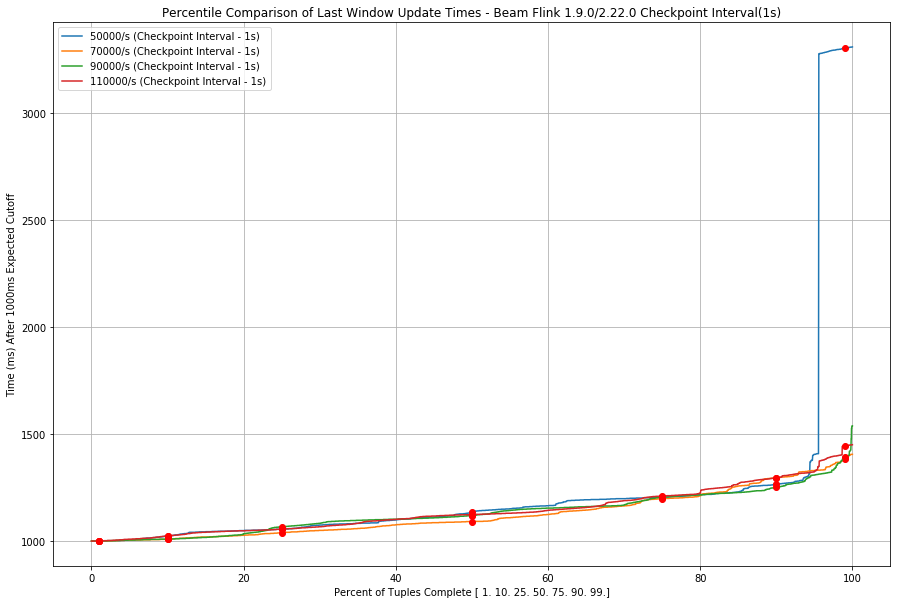

In [91]:
# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

def filter_and_sort(sorted_each, _, label):
    filtered_sorted = [x for x in sorted_each if x > 1000]
    perc = np.percentile(filtered_sorted, p)
    return (filtered_sorted, perc, label)

# Filter all data points <= 1000 ms
filtered_sorted = list()

for (sorted_each, _, label) in sorted:
    filtered_sorted.append(filter_and_sort(sorted_each, _, label))

# Do the actual drawing
plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in filtered_sorted:
    draw_line(points, percentiles, label)
    
plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After 1000ms Expected Cutoff')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Beam Flink 1.9.0/2.22.0 Checkpoint Interval(1s)')
plt.show()

# Storm latency/throughput for higher rate of events 200K/s to 400K/s Parallelism with 8x parallelism for bolts

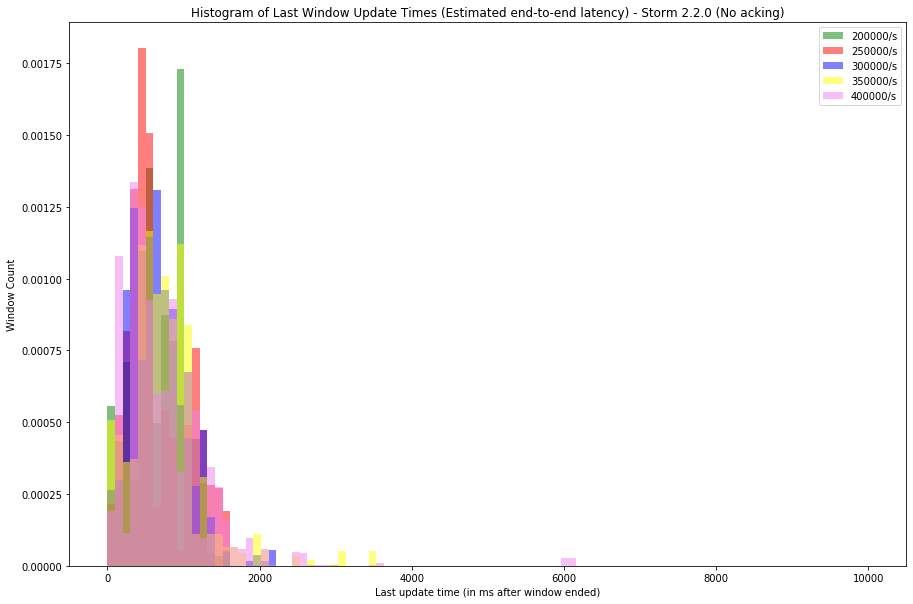

In [92]:
window_size_ms = 10000   #10 seconds (for me). Adjust to match your benchmark and common component.

files = [("../runs/results_4k/STORM/200000/updated.txt", "green", "200000"),
         ("../runs/results_4k/STORM/250000/updated.txt", "red", "250000"),
         ("../runs/results_4k/STORM/300000/updated.txt", "blue", "300000"),
         ("../runs/results_4k/STORM/350000/updated.txt", "yellow", "350000"),
         ("../runs/results_4k/STORM/400000/updated.txt", "violet", "400000")]
         
filtered = [(get_filtered_updated(filename, window_size_ms), color, label) for (filename, color, label) in files]
bins = np.linspace(0, 10000, 100)

plt.figure(num=None, figsize=(15, 10))
for (filter_each, color, label) in filtered:
    plt.hist(filter_each, bins, density=1, facecolor=color, alpha=0.5, label=label+"/s") 
plt.xlabel('Last update time (in ms after window ended)')
plt.ylabel('Window Count')
plt.title('Histogram of Last Window Update Times (Estimated end-to-end latency) - Storm 2.2.0 (No acking)')
plt.legend(loc="upper right")
plt.show()

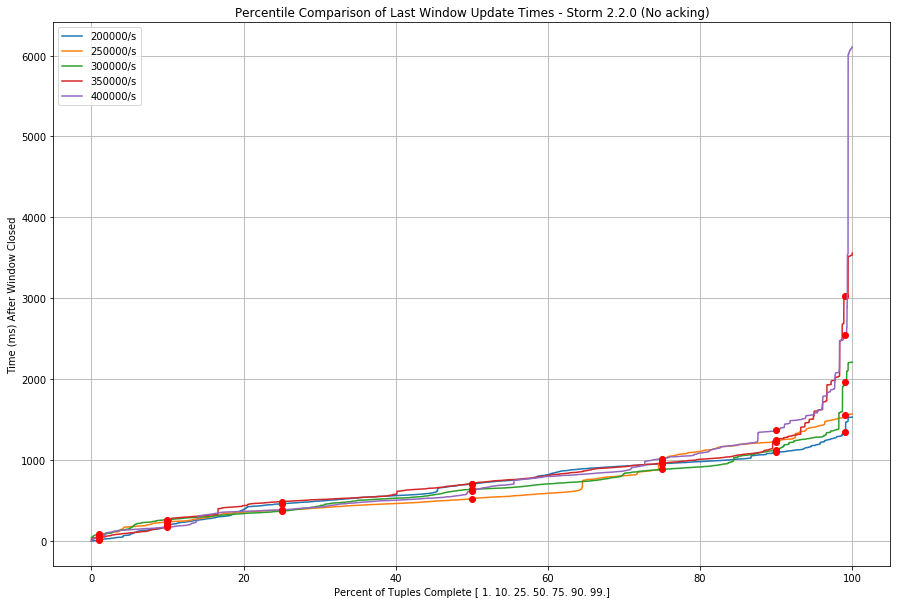

Percentiles:  [ 1. 10. 25. 50. 75. 90. 99.]


In [93]:
# Draws percentile charts from tuples of ([points], [percentiles], label)
def draw_line(points, percentiles, label):    
    plt.plot(np.linspace(0,100, len(points)), points, label=(label + "/s"))
    plt.plot(p, percentiles, 'ro')

# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

sorted = [(np.sort(filter), np.percentile(np.sort(filter), p), label) for (filter, _, label) in filtered]

# Do the drawing
f = plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in sorted:
    draw_line(points, percentiles,label)

plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After Window Closed')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Storm 2.2.0 (No acking)')
plt.show()

f.savefig("Storm_220_200k-400k_LWU.pdf", bbox_inches='tight')
print("Percentiles: ", p)

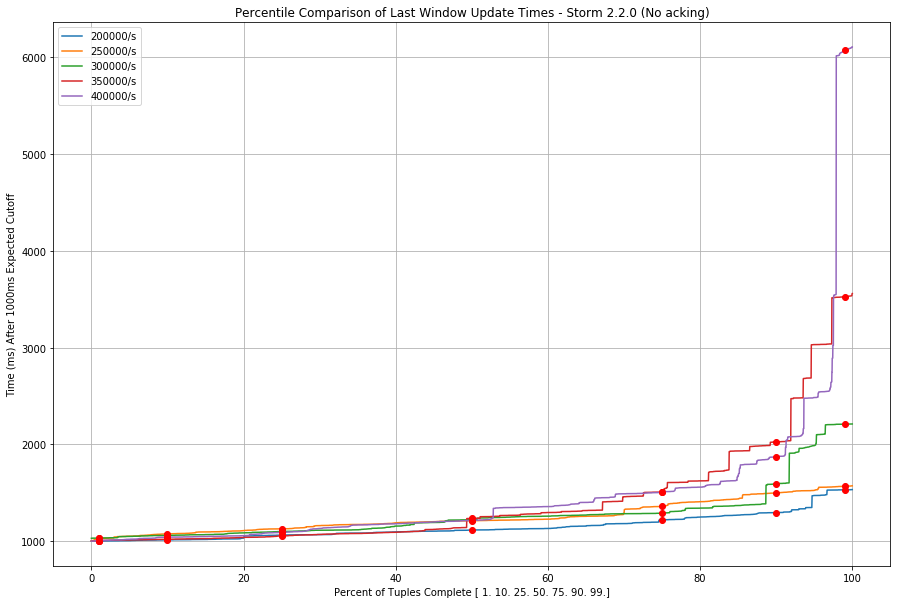

In [94]:
# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

def filter_and_sort(sorted_each, _, label):
    filtered_sorted = [x for x in sorted_each if x > 1000]
    perc = np.percentile(filtered_sorted, p)
    return (filtered_sorted, perc, label)

# Filter all data points <= 1000 ms
filtered_sorted = list()

for (sorted_each, _, label) in sorted:
    filtered_sorted.append(filter_and_sort(sorted_each, _, label))

# Do the actual drawing
plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in filtered_sorted:
    draw_line(points, percentiles, label)
    
plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After 1000ms Expected Cutoff')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Storm 2.2.0 (No acking)')
plt.show()

# Flink latency/throughput for higher rate of events 200K/s to 400K/s Parallelism with 8x parallelism for bolts

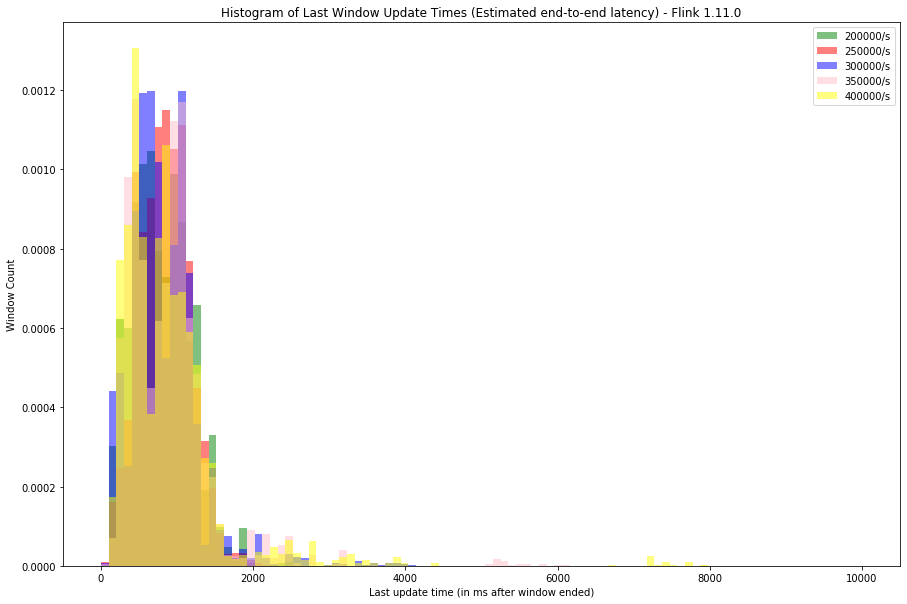

In [113]:
window_size_ms = 10000   #10 seconds (for me). Adjust to match your benchmark and common component.

files = [("../runs/results_4k/FLINK/200000/updated.txt", "green", "200000"),
         ("../runs/results_4k/FLINK/250000/updated.txt", "red", "250000"),
         ("../runs/results_4k/FLINK/300000/updated.txt", "blue", "300000"),
         ("../runs/results_4k/FLINK/350000/updated.txt", "pink", "350000"),
         ("../runs/results_4k/FLINK/400000/updated.txt", "yellow", "400000")]
         
filtered = [(get_filtered_updated(filename, window_size_ms), color, label) for (filename, color, label) in files]
bins = np.linspace(0, 10000, 100)

plt.figure(num=None, figsize=(15, 10))
for (filter_each, color, label) in filtered:
    plt.hist(filter_each, bins, density=1, facecolor=color, alpha=0.5, label=label+"/s") 
plt.xlabel('Last update time (in ms after window ended)')
plt.ylabel('Window Count')
plt.title('Histogram of Last Window Update Times (Estimated end-to-end latency) - Flink 1.11.0')
plt.legend(loc="upper right")
plt.show()

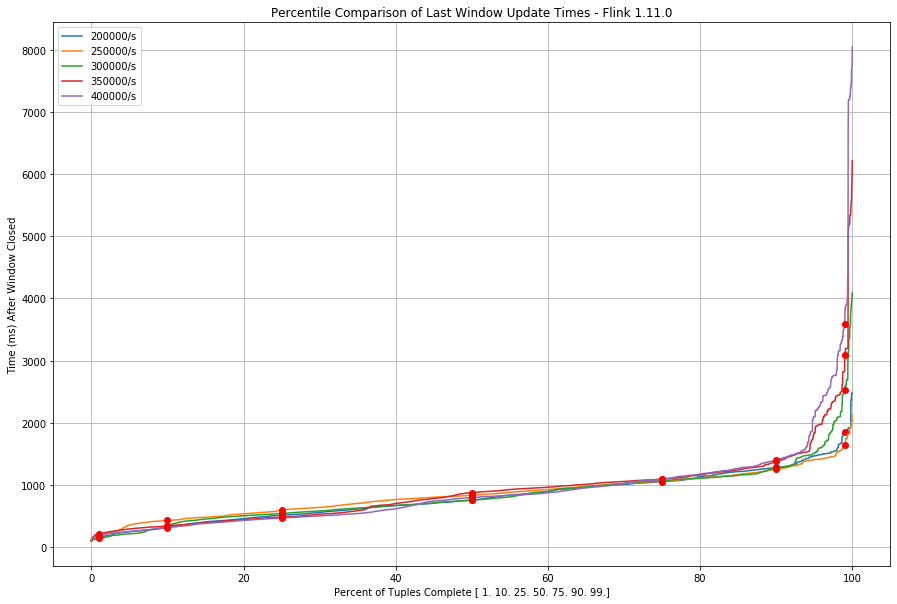

Percentiles:  [ 1. 10. 25. 50. 75. 90. 99.]


In [96]:
# Draws percentile charts from tuples of ([points], [percentiles], label)
def draw_line(points, percentiles, label):    
    plt.plot(np.linspace(0,100, len(points)), points, label=(label + "/s"))
    plt.plot(p, percentiles, 'ro')

# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

sorted = [(np.sort(filter), np.percentile(np.sort(filter), p), label) for (filter, _, label) in filtered]

# Do the drawing
f = plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in sorted:
    draw_line(points, percentiles,label)

plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After Window Closed')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Flink 1.11.0')
plt.show()
f.savefig("Flink_110_200k-400k_LWU.pdf", bbox_inches='tight')

print("Percentiles: ", p)

<function matplotlib.pyplot.show(*args, **kw)>

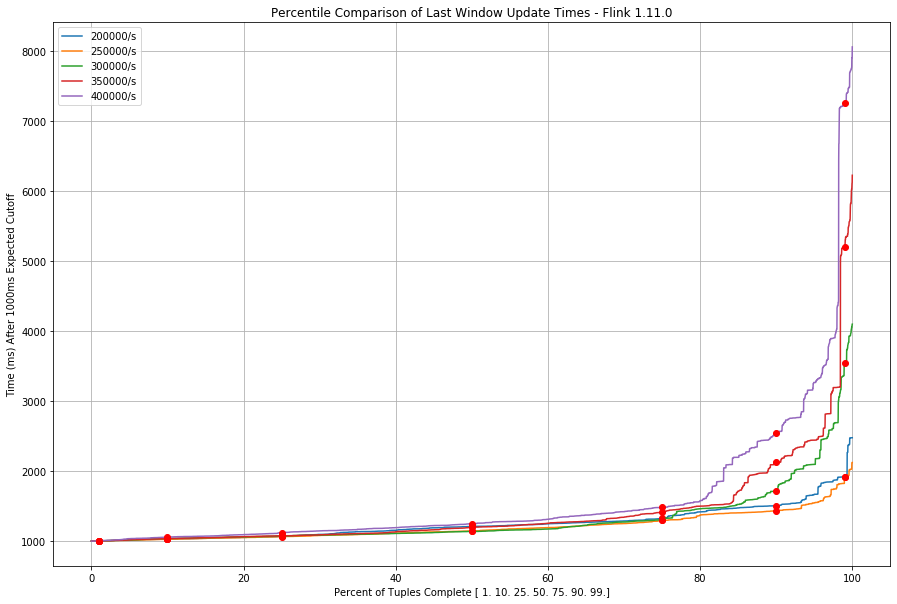

In [97]:
# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

def filter_and_sort(sorted_each, _, label):
    filtered_sorted = [x for x in sorted_each if x > 1000]
    perc = np.percentile(filtered_sorted, p)
    return (filtered_sorted, perc, label)

# Filter all data points <= 1000 ms
filtered_sorted = list()

for (sorted_each, _, label) in sorted:
    filtered_sorted.append(filter_and_sort(sorted_each, _, label))

# Do the actual drawing
plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in filtered_sorted:
    draw_line(points, percentiles, label)
    
plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After 1000ms Expected Cutoff')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Flink 1.11.0')
plt.show

# Storm/Flink Worker node Utilization with higher parallelism and higher rate of events

In [98]:
def get_utilization_stats(filename):
    utilization = np.loadtxt(filename, dtype=float)
    return utilization

def draw_line(points, label):    
    plt.plot(np.linspace(0,100, len(points)), points, label=(label))

In [99]:
files = [("../runs/cpu/storm_ysar_200_400_cpu_final.txt", "Storm CPU 200K/s-400K/s (Parallelism:432)"),
         ("../runs/cpu/storm_ysar_200_400_cpu_half_parallelism.txt", "Storm CPU 200K/s-400K/s(Parallelism:216)"),
         ("../runs/cpu/flink_ysar_200_400_cpu_final.txt", "Flink CPU 200K/s-400K/s")]

utilization_stats = [(get_utilization_stats(filename), label) for (filename, label) in files]

f = plt.figure(num=None, figsize=(15, 10))
for (points,label) in utilization_stats:
    draw_line(points,label)

plt.legend(loc="upper left")
plt.xlabel('Time Minutes')
plt.ylabel('CPU Utilization %')
plt.grid(True)
plt.title('Storm/Flink Memory Utilization for 200K, 250K, 300K, 350K, 400K events/sec over a period of time (Parallelism 432)')
plt.show()
f.savefig("Storm_Flink_CPU_200k-400k.pdf", bbox_inches='tight')

OSError: ../runs/cpu/storm_ysar_200_400_cpu_final.txt not found.

In [ ]:
files = [("../runs/mem/storm_ysar_200_400_mem_final.txt", "Storm MEM 200K/s-400K/s"),
         ("../runs/mem/flink_ysar_200_400_mem_final.txt", "FLink MEM 200K/s-400K/s (taskmanager.memory.managed.fraction: 0.1)"),
         ("../runs/flink_ysar_200_400_mem.txt", "FLink MEM 200K/s-400K/s (taskmanager.memory.managed.fraction: 0.4)")]

utilization_stats = [(get_utilization_stats(filename), label) for (filename, label) in files]

f = plt.figure(num=None, figsize=(15, 10))
for (points,label) in utilization_stats:
    draw_line(points,label)

plt.legend(loc="upper left")
plt.xlabel('Time Minutes')
plt.yticks(np.arange(0,100,10))
plt.ylabel('Memory Utilization %')
plt.grid(True)
plt.title('Storm/Flink Memory Utilization for 200K, 250K, 300K, 350K, 400K events/sec over a period of time (Parallelism 432)')
plt.show()
f.savefig("Storm_Flink_MEM_200k-400k.pdf", bbox_inches='tight')

In [ ]:
files = [("../runs/network/storm_ysar_200_400_inkbps_final.txt", "Storm inkbps"),
         ("../runs/network/storm_ysar_200_400_outkbps_final.txt", "Storm outkbps"),
         ("../runs/network/flink_ysar_200_400_inkbps_final.txt", "Flink inkbps"),
         ("../runs/network/flink_ysar_200_400_outkbps_final.txt", "Flink outkbps")]

utilization_stats = [(get_utilization_stats(filename), label) for (filename, label) in files]

f = plt.figure(num=None, figsize=(15, 10))
for (points,label) in utilization_stats:
    draw_line(points,label)

plt.legend(loc="upper left")
plt.xlabel('Time Minutes')
plt.ylabel('Network Utilization(kbps)')
plt.grid(True)
plt.title('Storm/Flink Network Utilization for 200K, 250K, 300K, 350K, 400K events/sec over a period of time (Parallelism 432)')
plt.show()
f.savefig("Storm_Flink_Network_200k-400k.pdf", bbox_inches='tight')

In [ ]:
files = [("../runs/cpu/storm_ysar_50_170_cpu_final.txt", "Storm CPU 50k/s-170k/s"),
         ("../runs/cpu/spark_dstream_ysar_50_170_cpu_final.txt", "Spark DStream CPU 50k/s-170k/s"),
         ("../runs/cpu/flink_ysar_50_170_cpu_final.txt", "Flink CPU 200K/s-400K/s")]

utilization_stats = [(get_utilization_stats(filename), label) for (filename, label) in files]

f = plt.figure(num=None, figsize=(15, 10))
for (points,label) in utilization_stats:
    draw_line(points,label)

plt.legend(loc="upper left")
plt.xlabel('Time Minutes')
plt.ylabel('CPU Utilization %')
plt.grid(True)
plt.title('Storm/Spark/Flink CPU Utilization for 50K, 70K, 90K, 110K, 130K, 135K, 150K, 170K events/sec over a period of time (Parallelism 72)')
plt.show()
f.savefig("Storm_Flink_Spark_CPU_50k-170k.pdf", bbox_inches='tight')

In [ ]:
files = [("../runs/mem/storm_ysar_50_170_mem_final.txt", "Storm MEM 50k/s-170k/s"),
         ("../runs/mem/spark_dstream_ysar_50_170_mem_final.txt", "Spark DStream MEM 50k/s-170k/s"),
         ("../runs/mem/flink_ysar_50_170_mem_final.txt", "Flink MEM 200K/s-400K/s (taskmanager.memory.managed.fraction: 0.1)"),
         ("../runs/flink_50_170_tm_06.txt", "Flink MEM 200K/s-400K/s (taskmanager.memory.managed.fraction: 0.6)")]

utilization_stats = [(get_utilization_stats(filename), label) for (filename, label) in files]

f = plt.figure(num=None, figsize=(15, 10))
for (points,label) in utilization_stats:
    draw_line(points,label)

plt.legend(loc="upper left")
plt.xlabel('Time Minutes')
plt.ylabel('Memory Utilization %')
plt.yticks(np.arange(0,100,10))
plt.grid(True)
plt.title('Storm/Spark/Flink Memory Utilization for 50K, 70K, 90K, 110K, 130K, 135K, 150K, 170K events/sec over a period of time (Parallelism 72)')
plt.show()
f.savefig("Storm_Flink_Spark_MEM_50k-170k.pdf", bbox_inches='tight')

In [ ]:
files = [("../runs/network/storm_ysar_50_170_inkbps_final.txt", "Storm inkbps"),
         ("../runs/network/spark_dstream_ysar_50_170_inkbps_final.txt", "Spark inkbps"),
         ("../runs/network/flink_ysar_50_170_inkbps_final.txt", "Flink inkbps"),
         ("../runs/network/storm_ysar_50_170_outkbps_final.txt", "Storm outkbps"),
         ("../runs/network/spark_dstream_ysar_50_170_outkbps_final.txt", "Spark outkbps"),
         ("../runs/network/flink_ysar_50_170_outkbps_final.txt", "Flink outkbps")]

utilization_stats = [(get_utilization_stats(filename), label) for (filename, label) in files]

f = plt.figure(num=None, figsize=(15, 10))
for (points,label) in utilization_stats:
    draw_line(points,label)

plt.legend(loc="upper left")
plt.xlabel('Time Minutes')
plt.ylabel('Network Utilization(kbps)')
plt.grid(True)
plt.title('Storm/Spark/Flink Network Utilization for 50K, 70K, 90K, 110K, 130K, 135K, 150K, 170K events/sec over a period of time (Parallelism 72)')
plt.show()
f.savefig("Storm_Flink_Spark_Network_50k-170k.pdf", bbox_inches='tight')

In [ ]:
files = [("../runs/mem/storm_ysar_200_400_mem_final.txt", "Storm MEM (G1GC) 200K/s-400K/s"),
         ("../runs/storm_ysar_200_400_mem.txt", "Storm MEM (CMS) 200K/s-400K/s")]

utilization_stats = [(get_utilization_stats(filename), label) for (filename, label) in files]

f = plt.figure(num=None, figsize=(15, 10))
for (points,label) in utilization_stats:
    draw_line(points,label)

plt.legend(loc="upper left")
plt.xlabel('Time Minutes')
plt.ylabel('Mem Utilization %')
plt.grid(True)
plt.title('Storm/Flink Memory Utilization for 200K, 250K, 300K, 350K, 400K events/sec over a period of time (Parallelism 432)')
plt.show()
f.savefig("Storm_Flink_MEM_CMS_G1GC_200k-400k.pdf", bbox_inches='tight')

# Latest numbers for Storm/Spark/Flink

In [102]:
window_size_ms = 10000   #10 seconds (for me). Adjust to match your benchmark and common component.

files = [#("../runs/results_4k/STORM/200000/updated.txt", "green", "200000"),
         #("../runs/results_4k/STORM/250000/updated.txt", "red", "250000"),
         #("../runs/results_4k/STORM/300000/updated.txt", "blue", "300000"),
         #("../runs/results_4k/STORM/350000/updated.txt", "yellow", "350000"),
         #("../runs/results_4k/STORM/400000/updated.txt", "violet", "400000"),
         #("../runs/results_600k_1m/600000/updated.txt", "magenta", "600000"),
          ("../runs/results_600k_1m/600000_1/updated.txt", "black", "600000_1"),
          ("../runs/results_600k_1m/600000_2/updated.txt", "red", "600000_2"),
          ("../runs/results_600k_1m/800000_4/updated.txt", "blue", "800000_4"),
          ("../runs/results_600k_1m/800000_5/updated.txt", "violet", "800000_5")]
         #("../runs/results_600k_1m/800000/updated.txt", "black", "800000"),
         #("../runs/results_600k_1m/800000_1/updated.txt", "black", "800000")]
         
filtered = [(get_filtered_updated(filename, window_size_ms), color, label) for (filename, color, label) in files]
bins = np.linspace(0, 10000, 100)

plt.figure(num=None, figsize=(15, 10))
for (filter_each, color, label) in filtered:
    plt.hist(filter_each, bins, density=1, facecolor=color, alpha=0.5, label=label+"/s") 
plt.xlabel('Last update time (in ms after window ended)')
plt.ylabel('Window Count')
plt.title('Histogram of Last Window Update Times (Estimated end-to-end latency) - Storm 2.2.0 (No acking)')
plt.legend(loc="upper right")
plt.show()

OSError: ../runs/results_600k_1m/600000_1/updated.txt not found.

In [ ]:
# Draws percentile charts from tuples of ([points], [percentiles], label)
def draw_line(points, percentiles, label):    
    plt.plot(np.linspace(0,100, len(points)), points, label=(label + "/s"))
    plt.plot(p, percentiles, 'ro')

# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

sorted = [(np.sort(filter), np.percentile(np.sort(filter), p), label) for (filter, _, label) in filtered]

# Do the drawing
f = plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in sorted:
    draw_line(points, percentiles,label)

plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After Window Closed')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Storm 2.2.0 (No acking)')
plt.show()

f.savefig("Storm_220_200k-400k_LWU.pdf", bbox_inches='tight')
print("Percentiles: ", p)

# Storm Trident Micro Batch (Batch Interval - 500ms)

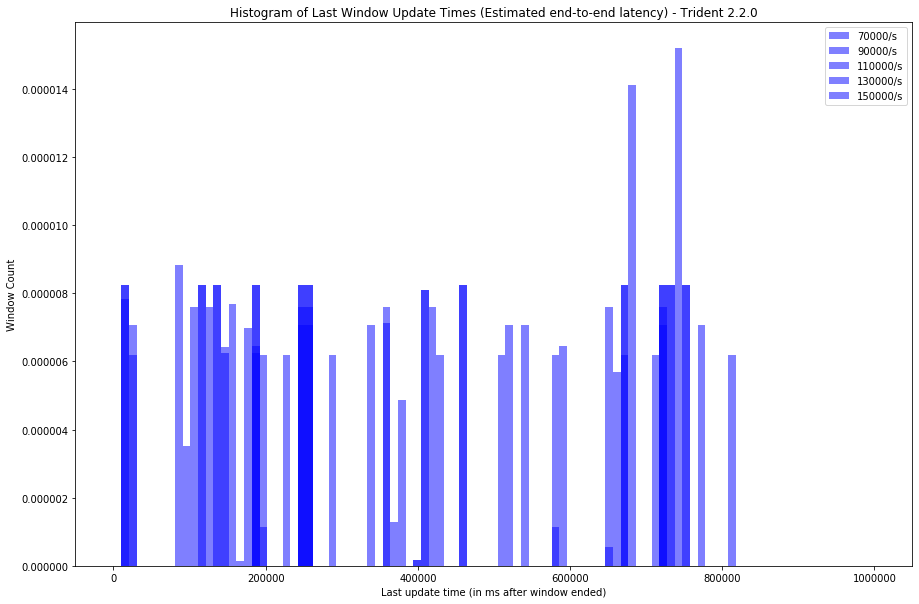

In [115]:
window_size_ms = 10000   #10 seconds (for me). Adjust to match your benchmark and common component.

files = [("../runs/results/TRIDENT_STORM/70000/updated.txt", "blue", "70000"),
         ("../runs/results/TRIDENT_STORM/90000/updated.txt", "blue", "90000"),
         ("../runs/results/TRIDENT_STORM/110000/updated.txt", "blue", "110000"),
         ("../runs/results/TRIDENT_STORM/130000/updated.txt", "blue", "130000"),
         ("../runs/results/TRIDENT_STORM/130000/updated.txt", "blue", "150000")]
         
filtered = [(get_filtered_updated(filename, window_size_ms), color, label) for (filename, color, label) in files]
bins = np.linspace(0, 1000000, 100)

plt.figure(num=None, figsize=(15, 10))
#print(filtered)
for (filter_each, color, label) in filtered:
    plt.hist(filter_each, bins, density=1, facecolor=color, alpha=0.5, label=label+"/s") 
plt.xlabel('Last update time (in ms after window ended)')
plt.ylabel('Window Count')
plt.title('Histogram of Last Window Update Times (Estimated end-to-end latency) - Trident 2.2.0')
plt.legend(loc="upper right")
plt.show()

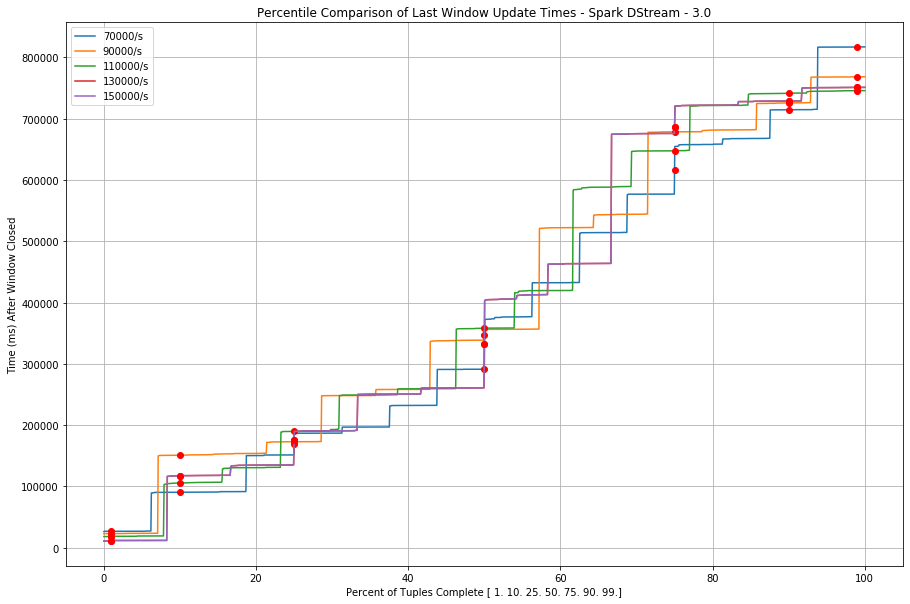

Percentiles:  [ 1. 10. 25. 50. 75. 90. 99.]


In [117]:
def draw_line(points, percentiles, label):    
    plt.plot(np.linspace(0,100, len(points)), points, label=(label + "/s"))
    plt.plot(p, percentiles, 'ro')

# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0])

#print(filtered)
sorted = [(np.sort(filter), np.percentile(np.sort(filter), p), label) for (filter, _, label) in filtered]
#print(sorted)
# Do the drawing
f = plt.figure(num=None, figsize=(15, 10))

for (points, percentiles, label) in sorted:
    draw_line(points, percentiles,label)

plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete [ 1. 10. 25. 50. 75. 90. 99.]')
plt.ylabel('Time (ms) After Window Closed')
plt.grid(True)
plt.title('Percentile Comparison of Last Window Update Times - Spark DStream - 3.0')
plt.show()
f.savefig("Spark_DStream_30_LWU.pdf", bbox_inches='tight')
print("Percentiles: ", p)

# Spark Structured Streaming Micro Batch Trigger 3s

# Storm NUMA Awareness

# Flink on Yarn

# Spark on Yarn